# `Определение стоимости автомобилей` - проект Мастерской Яндекс на платформе Kaggle.

**Автор:**

* Бессонов Евгений  
* [Адрес в телеграмм](https://t.me/EMskv "t.me/EMskv")  
* [Портфолио с JupiterNotebook проекта](https://github.com/evgeniy-yandex/Data_Science "github")

# Описание проекта.

**Описание данных**

* `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
* `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.
* `sample_submission.csv` - пример файла предсказаний в правильном формате.
* `vin` - идентификатор автомобиля в тестовом наборе.
* `sellingprice` - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

**Задача на проект** 

1. На основе данных файла `train.csv` разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.
2. Рассчитать значение стоимости автомобиля для датасета из файла `test.csv`.   
   В качестве примера файла предсказаний в правильном формате предложен файл `sample_submission.csv`

**Описание полей данных**
* `year`: год выпуска автомобиля.
* `make`: марка автомобиля.
* `model`: издание автомобиля определенной марки.
* `trim`: уровни отделки салона автомобиля — это просто разные версии модели.
* `body`: тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
* `transmission`: тип коробки передач.
* `vin`: идентификационный номер транспортного средства.
* `state`: состояние, в котором автомобиль выставлен на аукцион.
* `condition`: состояние автомобилей на момент аукциона.
* `odometer`: расстояние, пройденное автомобилем с момента выпуска.
* `color`: цвет кузова автомобиля.
* `interior`: цвет салона автомобиля.
* `seller`: продавец автомобиля, автосалоны.
* `sellingprice`: цена, по которой автомобиль был продан на аукционе.
* `saledate`: дата продажи автомобиля.


**План работы.**

1. Загружаем данные из файлов `train.csv`, `test.csv`, `sample_submission.csv` и изучаем их.  
2. Объединяем данные из файлов `train.csv`, `test.csv`и одинаково их обрабатываем:
    * Заполняем и удаляем пропущенные значения.
    * Обработаем аномалии в признаках, используя распределения 'ящик с усами'.
    * Дополняем данные по признакам `make` и `model` из данных, которые можно плучить их `vin`
    * Создаём синтетические признаки и удаляем неинформативные.  
3. Снова разбиваем датасеты на train и test по наличию признака `sellingprice`.
4. Делим датасет train на обучающую и тестовую выборки в пропорции.
5. Изучаем мультиколлинеарность количественных признаков.
6. Рассматриваем зависимость количественных и целевого признаков.
7. Проводим масштабирование численных признаков отдельно обучающей и тестовой выборок.
8. Кодируем категориальных признаков отдельно обучающей и тестовой выборок.
9. Создаём функцию расчета метрики качества - MAPE.
10. Создаём и обучаем модели на основе `Pipeline` в `GridSearchCV`.
11. Выбираем лучшую модель.
12. Проверяем лучшую можедь на адекватность по константной модели.
12. Определяем качество лучшей модели на тестовой выборке.
13. Проводим изучение важности признаков.
14. Проводим сериализацию модели.
15. Рассчитываем значение предсказания по данным выборки test.
16. Формируем датасет с результатами расчёта выборки test и сохраняем его в файл.
17. Оформляем итоговые выводы.

**Примечания:**
* Для оценки качества моделей применяем метрику [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error "Mean Absolute Percentage Error"):
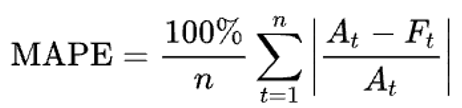

In [1]:
#!pip install vininfo -q
#!pip install pytz

In [2]:
# Все import соберем в начале проекта:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import time
import pytz
import pickle
from skimpy import skim
from vininfo import Vin
from datetime import datetime 


import matplotlib.pyplot as plt
from sklearn.preprocessing import (OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler)
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV, KFold,
                                     RandomizedSearchCV)
from scipy.stats import uniform, loguniform
from tqdm.auto import tqdm

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  ElasticNet)
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor)
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.dummy import DummyRegressor


# Введем глобальную переменные:
RANDOM_STATE_FIX = 12345
LOCAL_TIME_ZONE = 'Europe/Moscow'

# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Настроим, чтобы числа в датасетах отражались с 1 знаком после запятой
pd.set_option('display.float_format', '{:.1f}'.format) 

# Загрузка файла с данными:

Изучили файлы с предоставленными данными `train.csv` и `test.csv`, решили использовать символ **запятая** для разделения данных:

In [3]:
file_train_data = 'train.csv'           # Обучающие данные
file_test_data = 'test.csv'             # Тестовые данные
file_example_data = 'sample_submission.csv'  # Пример файла предсказаний

def load_dataset(file_name):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        data = pd.read_csv(file_name, sep=',')
        print('Dataset', file_name, 'is loaded successfully.')
        return data
    else:
        print('Something with', file_name, 'is wrong.')
    
# Загрузка обучающего датасета    
data_train = load_dataset(file_train_data);

# Загрузка тестового датасета    
data_test = load_dataset(file_test_data);     

# Загрузка файла предсказаний  
data_example = load_dataset(file_example_data);  

Dataset train.csv is loaded successfully.
Dataset test.csv is loaded successfully.
Dataset sample_submission.csv is loaded successfully.


# Изучим датасет и проведем первичную обработку данных.

Так как у нас есть отдельно обучающий датасет и тестовый датасет, создадим вспомогательную функцию для единообразного изучения датафрейма.

In [4]:
def view_df(df):
    '''
    Функция для единообразного изучения датафреймов.
    1. Контроль размера датасета.
    2. Проверка на соответствие наименований столбцов стилю snake_case.
    3. Вывод основных данных по датасету.
    4. Распечатка на экране первых трёх объектов датасета.
    
    В дальнейшем вероятно, будем избавляться от части объектов. Чтобы понимать, 
    какую часть данных потеряли, сохраним возвращая, 
    начальное значение количества объектов в датасете:
    '''
    df.shape, df.size
    columns_name = df.columns.tolist()
    print(columns_name)
    skim(df)
    display(df.head(3))
    display(df.tail(3))
    print('Количество дубликатов:', df.duplicated().sum())
    
    return df.shape[0]

## Изучим данные, содержащиеся в датафреймах.

### Анализ значений датафрейма `train`:

In [5]:
# Изучим содержимое датафрейма `train`:

initial_size_train = view_df(data_train)

['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice', 'saledate']


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 440236 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 15     │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA     ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100      ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩  │
│ │ year             │      0 │       0 │    2000 │       4 │   2000 │    2000 │    2000 │      2000 │    ▁▃█  │  │
│ │ condition        │   9400 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │     4.2 │         5 │  ▄▄▅█▅  │  │
│ │ odometer         │     69 │   0.016 │   68000 │   54000 │      1 │   28000 │   99000 │   1000000 │    █    │  │
│ │ sellingprice     │      0 │       0 │   14000 │    9800 │      1 │    6900 │   18000 │    230000 │    █    │  │
│ └──────────────────┴────────┴─────────┴─────────┴─────────┴────────┴─────────┴─────────┴───────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │         8000 │        1.8 │                       0.99 │                430000 │  │
│ │ model                     │         8100 │        1.8 │                       0.99 │                430000 │  │
│ │ trim                      │         8300 │        1.9 │                       0.99 │                430000 │  │
│ │ body                      │        10000 │        2.4 │                       0.99 │                430000 │  │
│ │ transmission              │        51000 │         12 │                       0.99 │                430000 │  │
│ │ vin                       │            0 │          0 │                       0.99 │                430000 │  │
│ │ state                     │            0 │          0 │                       0.99 │                430000 │  │
│ │ color                     │          590 │       0.13 │                       0.99 │                430000 │  │
│ │ interior                  │          590 │       0.13 │                       0.99 │                430000 │  │
│ │ seller                    │            0 │          0 │                       0.99 │                430000 │  │
│ │ saledate                  │            0 │          0 │                       0.99 │                430000 │  │
│ └───────────────────────────┴──────────────┴────────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── 

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
440233,2008,BMW,6 Series,650i,Coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,gray,black,studio city auto group,16750,Tue Mar 03 2015 04:30:00 GMT-0800 (PST)
440234,2014,Ram,2500,SLT,Crew Cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,white,gray,express car & truck rental,33000,Wed Jan 14 2015 02:05:00 GMT-0800 (PST)
440235,2013,Nissan,Rogue,SV,SUV,automatic,jn8as5mt9dw038107,il,3.5,27924.0,silver,gray,"ec sales,llc",14500,Thu Jan 15 2015 02:00:00 GMT-0800 (PST)


Количество дубликатов: 0


**Промежуточные выводы по датасету `train`:**
    
1. Набор данных довольно большой: 440 236 строк х 15 столбцов. Замечательно!
2. Видим, что наименования столбцов соответствуют стилю *snake_case*. Дополнительной правки не требуется. 
3. В дальнейшем к признакам можно обращаться через точку.
4. Пропуски значений в 9 признаков из 15.
5. Целевым является признак `sellingprice`. И в нём нет пропусков.
6. Видим, что в нашем датасете есть и количественные и категориальные признаки.
7. Значение количества объектов в исходном датасете сохранено.

### Анализ значений датафрейма `test`:

In [6]:
# Изучим содержимое датафрейма `test`:

initial_size_test = view_df(data_test)

['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'saledate']


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 110058 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 14     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA     ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100       ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩  │
│ │ year            │      0 │       0 │    2000 │       4 │   2000 │    2000 │    2000 │       2000 │    ▁▃█  │  │
│ │ condition       │   2400 │     2.2 │     3.4 │    0.95 │      1 │     2.7 │     4.2 │          5 │  ▄▅▆█▅  │  │
│ │ odometer        │     19 │   0.017 │   68000 │   54000 │      1 │   28000 │   99000 │    1000000 │    █    │  │
│ └─────────────────┴────────┴─────────┴─────────┴─────────┴────────┴─────────┴─────────┴────────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │         2100 │        1.9 │                       0.98 │                110000 │  │
│ │ model                     │         2100 │        1.9 │                       0.98 │                110000 │  │
│ │ trim                      │         2100 │        1.9 │                       0.98 │                110000 │  │
│ │ body                      │         2600 │        2.4 │                       0.98 │                110000 │  │
│ │ transmission              │        13000 │         12 │                       0.98 │                110000 │  │
│ │ vin                       │            0 │          0 │                       0.98 │                110000 │  │
│ │ state                     │            0 │          0 │                       0.98 │                110000 │  │
│ │ color                     │          160 │       0.14 │                       0.98 │                110000 │  │
│ │ interior                  │          160 │       0.14 │                       0.98 │                110000 │  │
│ │ seller                    │            0 │          0 │                       0.98 │                110000 │  │
│ │ saledate                  │            0 │          0 │                       0.98 │                110000 │  │
│ └───────────────────────────┴──────────────┴────────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
110055,2004,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e54c831950,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,Thu Feb 05 2015 01:35:00 GMT-0800 (PST)
110056,2013,Nissan,370Z,Base,coupe,manual,jn1az4eh3dm382431,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,Wed Jun 17 2015 03:30:00 GMT-0700 (PDT)
110057,2012,Chevrolet,Camaro,LS,Coupe,NaN,2g1fa1e32c9193058,pa,3.7,40399.0,blue,black,ingersoll auto of danbury,Fri Jan 09 2015 09:00:00 GMT-0800 (PST)


Количество дубликатов: 0


**Промежуточные выводы по контрольному датасету `test`:**
    
1. Набор данных довольно большой: 110 058 строк х 14 столбцов. 
2. Видим, что структура датасета такая же, как и датасета `train`.   
   Даже пропуски в тех же самых признаках.   
   С той лишь разницей, что здесь отсутствует целевой признак `sellingprice`.
3. В связи с тем, что мы будем создавать новые признаки и избавляться от неинформативных, для того, чтобы состав признаков был одинаковым для обоих датасетов, объединим их. Проведём единообразно работу по созданию итоговых признаков и уже далее, до кодирования признаков и создания моделей, разделим их снова на `train` и `test` датасеты. Характеристикой принадлежности к `train` будет наличие значения в `sellingprice`, характеристикой принадлежности к `test` - его отсутствие, т.е. NaN.    

### Анализ значений датафрейма `sample_submission`:

In [7]:
# Изучим содержимое файла предсказаний 'sample_submission.csv':

data_example.sample(5)

,vin,sellingprice
8303,1n4aa5ap9dc800994,13592.2
3049,1g8jd54r85y506547,13592.2
43681,1j4ga39177l228279,13592.2
27481,1c3cdzab9cn186042,13592.2
80557,1n4al2ap7cn567886,13592.2


**Промежуточные выводы по контрольному датасету `data_sample` файла `sample_submission.csv`:**
    
Результатом всей работы над проектом должен стать файл с id и vin датасета `test`, содержащий предсказанные значения стоимости автомобиля.

In [8]:
# Сделаем функцию расчета количества оставшихся после сокращений объектов:
def check_number_objects(df, initial_size): 
    '''
    функция расчета количества оставшихся после сокращений объектов
    '''
    print(f'Количество объектов в изначальном датасете: \
{initial_size:_d} шт.')
    print(f'Количество объектов в текущем датасете: \
{df.shape[0]:_d} шт.')
    print(f'После всех сокращений осталось: \
{df.shape[0] / initial_size:.2%}')

### Объединение датасетов `train` и `test`.

In [9]:
data = data_train.append(data_test)
data.reset_index(drop= True , inplace= True ) # сбросить индекс
view_df(data) 

['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice', 'saledate']


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 550294 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 15     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA       ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75    ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ year             │        0 │       0 │    2000 │       4 │   2000 │    2000 │   2000 │      2000 │    ▁▃█ │  │
│ │ condition        │    12000 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │    4.2 │         5 │  ▄▄▅█▅ │  │
│ │ odometer         │       88 │   0.016 │   68000 │   54000 │      1 │   28000 │  99000 │   1000000 │   █    │  │
│ │ sellingprice     │   110000 │      20 │   14000 │    9800 │      1 │    6900 │  18000 │    230000 │   █    │  │
│ └──────────────────┴──────────┴─────────┴─────────┴─────────┴────────┴─────────┴────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │        10000 │        1.8 │                       0.99 │                540000 │  │
│ │ model                     │        10000 │        1.9 │                       0.99 │                540000 │  │
│ │ trim                      │        10000 │        1.9 │                       0.99 │                540000 │  │
│ │ body                      │        13000 │        2.4 │                       0.99 │                540000 │  │
│ │ transmission              │        64000 │         12 │                       0.99 │                540000 │  │
│ │ vin                       │            0 │          0 │                       0.99 │                540000 │  │
│ │ state                     │            0 │          0 │                       0.99 │                540000 │  │
│ │ color                     │          740 │       0.14 │                       0.99 │                540000 │  │
│ │ interior                  │          740 │       0.14 │                       0.99 │                540000 │  │
│ │ seller                    │            0 │          0 │                       0.99 │                540000 │  │
│ │ saledate                  │            0 │          0 │                       0.99 │                540000 │  │
│ └───────────────────────────┴──────────────┴────────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── 

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500.0,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500.0,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100.0,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
550291,2004,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e54c831950,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,NaN,Thu Feb 05 2015 01:35:00 GMT-0800 (PST)
550292,2013,Nissan,370Z,Base,coupe,manual,jn1az4eh3dm382431,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,NaN,Wed Jun 17 2015 03:30:00 GMT-0700 (PDT)
550293,2012,Chevrolet,Camaro,LS,Coupe,NaN,2g1fa1e32c9193058,pa,3.7,40399.0,blue,black,ingersoll auto of danbury,NaN,Fri Jan 09 2015 09:00:00 GMT-0800 (PST)


Количество дубликатов: 0


550294

**Промежуточные выводы по объединенному датасету `data`:**
    
1. Обратим внимание на признак *vin*. Сам по себе он неинформативен при использовани для построения моделей.
   Но из него можно получить много информации, отсутствующей в других признаках, таких как:
    * **year** - год выпуска автомобиля,
    * **make** - марка автомобиля.
    * **model** - издание автомобиля определенной марки.
    * **body**  - тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
    * **transmission** - тип коробки передач.

Информацию по расшифроки vin можно получить по ссылке: 
https://en.wikipedia.org/wiki/Vehicle_identification_number#Check-digit_calculation 


### Рассмотрим категориальные признаки.

Создадим специальную функцияю для обобщения редких продаж для различных признаках.

In [10]:
def category_priznak(column_name, range_columns,
                    title_plot):
    '''
    Обобщение продаж авто с малой частотой по разным признакам
    '''
    # Частотность продажи авто:
    data['freq'] = data.groupby(column_name)[column_name].transform('count')
    
    # Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
    for _ in tqdm(range(1)): 
        def cat_body(row):
            for num in range_columns:
                if row['freq'] <= num:   
                    return 'less'+ str(num) + 'cars'
            return row[column_name]
        
        data[column_name] = data.apply(cat_body, axis=1)
    
    plt.figure(figsize=(12, 6))
    my_plot = sns.countplot(x = column_name, data = data,
                           order=data[column_name].value_counts().index);
    my_plot.set(title=title_plot);
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=60,
                            horizontalalignment='right')
    plt.show()
    
    print(data[column_name].value_counts())
        
    data.drop('freq', axis= 1 , inplace= True)

#### Признак `make` - марка автомобиля.

Воспользуемся функцией **Vin** модуля *vininfo* для извлечения информации о заводе-производителе и стране производства автомобиля.

In [11]:
# Создадим пару вспомогательных функций

def calc_country_maker(row):
    '''
    Функция чтения страны-производителя автомобиля.
    '''
    vin = Vin(row['vin'])   
    return vin.country

def calc_maker(row):
    '''
    Функция чтения завода-изготовителя автомобиля.
    '''
    vin = Vin(row['vin'])   
    return vin.manufacturer

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):

    # Новый признак с информацией о стране-производителе автомобиля.
    data['country'] = data.apply(calc_country_maker, axis=1)

    # Новый временный признак с информацией о заводе-изготовителе автомобиля.
    data['maker'] = data.apply(calc_maker, axis=1)

    # Заполним пустые ячейки признака 'make'
    data.make = data.make.fillna(data.maker)
    # удалим временный признак
    data.drop('maker', axis= 1 , inplace= True )

    # Приведем все записи 'make' к нижнему регистру.
    data.make = data.make.str.lower()

display(data.sample(3))

  0%|          | 0/1 [00:00<?, ?it/s]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,country
131234,2009,chevrolet usa,NaN,NaN,NaN,automatic,1gbgg25c291158117,ca,2.5,103353.0,white,beige,ge fleet services for itself/servicer,9800.0,Thu May 28 2015 05:00:00 GMT-0700 (PDT),United States
379487,2007,hyundai,Santa Fe,GLS,SUV,automatic,5nmsg73d77h079883,ma,3.5,145695.0,white,gray,capital one auto finance,4200.0,Tue Jan 20 2015 01:30:00 GMT-0800 (PST),United States
429980,2013,acura,ILX,Technology Package,sedan,automatic,19vde1f73de005812,nj,3.6,27102.0,black,black,"ahfc/honda lease trust/hvt, inc. eot",19200.0,Wed Jun 03 2015 02:30:00 GMT-0700 (PDT),United States


In [12]:
display(data.country.unique())

array(['Canada', 'Mexico', 'United States', 'South Korea', 'Japan',
       'Sweden', 'Germany', 'United Kingdom', 'Brazil', 'Italy', 'Turkey',
       'Thailand', 'Finland', 'Hungary', 'Australia', 'France'],
      dtype=object)

In [13]:
# Поменяем названия стран на более короткие.
data.country = data.country.replace(
    {'United States': 'USA', 'South Korea': 'Korea',
     'United Kingdom': 'England'}
)
display(data.country.unique())
# Количество пропущенных значений
print(data.country.isnull().sum())

array(['Canada', 'Mexico', 'USA', 'Korea', 'Japan', 'Sweden', 'Germany',
       'England', 'Brazil', 'Italy', 'Turkey', 'Thailand', 'Finland',
       'Hungary', 'Australia', 'France'], dtype=object)

0


In [14]:
# Проверим имена компаний-производителей проданных авто на адекватность.
display(data.make.unique())

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'toyota', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes-benz', 'volkswagen', 'mazda',
       'bmw', 'infiniti', 'chrysler', 'kia', 'chevrolet usa', 'jaguar',
       'subaru', 'jeep', 'lexus', 'mercedes', 'scion', 'chevrolet mexico',
       'fiat', 'suzuki', 'land rover', 'volvo', 'audi', 'cami', 'mini',
       'isuzu', 'gmc truck', 'mitsubishi', 'chrysler canada', 'smart',
       'porsche', 'saturn', 'ram', 'daimlerchrysler ag/daimler ag',
       'oldsmobile', 'dodge canada', 'mercury', 'porsche car', 'bentley',
       'fisker', 'dodge mexico', 'maserati', 'genesis', 'tesla',
       'landrover', 'vw', 'daimler ag (sprinter)', 'am',
       'chevrolet canada', 'rolls-royce', 'ferrari', 'plymouth',
       'lamborghini', 'unsupportedbrand', 'geo', 'ford truck',
       'aston martin', 'daewoo', 'mercedes-benz (sprinter)', 'mercedes-b',
       'dodge tk', 'volkswagen comm

In [15]:
# Приведём к единому виду повторяющиеся названия компаний-производителей авто.
data.make = data.make.replace(
    {'mercedes-benz': 'mercedes', 
     'chevrolet usa': 'chevrolet',
     'chevrolet mexico': 'chevrolet', 
     'chrysler canada': 'chrysler',
     'daimlerchrysler ag/daimler ag': 'mercedes',
     'dodge canada': 'dodge',
     'porsche car': 'porsche',
     'dodge mexico': 'dodge',
     'vw': 'volkswagen',
     'daimler ag (sprinter)': 'mercedes',
     'chevrolet canada': 'chevrolet',
     'chevrolet ': 'chevrolet',
     'mercedes-benz (sprinter)': 'mercedes',
     'mercedes-b': 'mercedes',
     'volkswagen commercial vehicles': 'volkswagen',
     'porsche suv': 'porsche',
     'bmw m': 'bmw',                            
     'lexus canada': 'lexus',
     'land rover': 'landrover',
     'gmc truck': 'gmc tk', 'ford truck': 'ford tk', 'chev truck': 'chevrolet tk',
     'gmc tk': 'truck', 'gmc truck': 'truck',
     'ford truck': 'truck', 'ford tk': 'truck', 'chev truck': 'truck',
     'dodge tk': 'truck', 'mazda tk': 'truck', 'chevrolet truck': 'truck',
     'hyundai tk': 'truck', 'chevrolet tk':  'truck', 'airstream': 'truck',
     'ferrari': 'sport_car',
     'lamborghini': 'sport_car',
     'aston martin': 'sport_car',
     'lotus': 'sport_car'}
)
# Приведем все записи 'make' к нижнему регистру.
data.make = data.make.str.lower()

display(data.make.unique())
# Количество пропущенных значений
print(data.make.isnull().sum())

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'toyota', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes', 'volkswagen', 'mazda', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'scion', 'fiat', 'suzuki', 'landrover', 'volvo', 'audi', 'cami',
       'mini', 'isuzu', 'truck', 'mitsubishi', 'smart', 'porsche',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'genesis', 'tesla', 'am', 'rolls-royce', 'sport_car',
       'plymouth', 'unsupportedbrand', 'geo', 'daewoo', 'dot'],
      dtype=object)

0


**Отмечаем** непонятные значения `unsupportedbrand` и `am`. Разберемся с ними.

In [16]:
# Посмотрим объекты, имеющие значение признака 'make'
# равное 'unsupportedbrand' и 'am':
li = ['unsupportedbrand', 'am']
data[data.make.isin(li)]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,country
15531,2002,am,NaN,NaN,NaN,automatic,137fa90362e197965,nc,2.5,79808.0,white,gray,performance auto center inc,36000.0,Mon Feb 23 2015 01:30:00 GMT-0800 (PST),USA
49873,1998,unsupportedbrand,NaN,NaN,NaN,automatic,4g2jb32t1wb202417,md,1.0,131716.0,white,white,purple heart services inc,350.0,Tue Jan 20 2015 04:00:00 GMT-0800 (PST),USA
135784,2007,unsupportedbrand,NaN,NaN,NaN,automatic,4gldv13w27d199384,pa,2.5,91200.0,red,gray,adcock brothers inc,8500.0,Fri Feb 20 2015 09:00:00 GMT-0800 (PST),USA
141702,2007,unsupportedbrand,NaN,NaN,NaN,automatic,4gldv13w37d203460,pa,3.8,107834.0,silver,gray,mascio motor car,9000.0,Tue Feb 17 2015 01:30:00 GMT-0800 (PST),USA
369258,1990,unsupportedbrand,NaN,NaN,NaN,manual,2j4fy19e4lj510779,ca,1.0,203130.0,red,gray,pass auto center,2500.0,Tue Mar 03 2015 04:30:00 GMT-0800 (PST),Canada
392088,2000,am,NaN,NaN,NaN,automatic,137za8435ye187468,ca,2.3,84028.0,silver,tan,aaero sweet company,42000.0,Thu Feb 05 2015 03:30:00 GMT-0800 (PST),USA


In [17]:
# Заменим их значеними, из соответствутющих vin кодам
# https://ru.vindecoder.pl/4G2JB32T1WB202417

unsupp = ((49873, ('make', 'pontiac'), ('model', 'Sunfire'), ('body', 'Convertible')),
          (135784,('make', 'buick'), ('model', 'Terraza'), ('body', 'Van')),
          (141702,('make', 'buick'), ('model', 'Terraza'), ('body', 'Van')),
          (369258,('make', 'jeep'), ('model', 'Wrangler'), ('body', 'Convertible')),
          (15531,('make', 'hummer'), ('model', 'H1'), ('body', 'Opentop')),
          (392088,('make', 'hummer'), ('model', 'AM General'), ('body', 'SUV'))
         )

for i in range(len(unsupp)):
    for j in range(1,len(unsupp[0])):
        data.loc[unsupp[i][0], unsupp[i][j][0]] = unsupp[i][j][1]

# Проверим результат замены:
pos = [49873, 135784, 141702, 369258, 15531, 392088]
data.iloc[pos]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,country
49873,1998,pontiac,Sunfire,NaN,Convertible,automatic,4g2jb32t1wb202417,md,1.0,131716.0,white,white,purple heart services inc,350.0,Tue Jan 20 2015 04:00:00 GMT-0800 (PST),USA
135784,2007,buick,Terraza,NaN,Van,automatic,4gldv13w27d199384,pa,2.5,91200.0,red,gray,adcock brothers inc,8500.0,Fri Feb 20 2015 09:00:00 GMT-0800 (PST),USA
141702,2007,buick,Terraza,NaN,Van,automatic,4gldv13w37d203460,pa,3.8,107834.0,silver,gray,mascio motor car,9000.0,Tue Feb 17 2015 01:30:00 GMT-0800 (PST),USA
369258,1990,jeep,Wrangler,NaN,Convertible,manual,2j4fy19e4lj510779,ca,1.0,203130.0,red,gray,pass auto center,2500.0,Tue Mar 03 2015 04:30:00 GMT-0800 (PST),Canada
15531,2002,hummer,H1,NaN,Opentop,automatic,137fa90362e197965,nc,2.5,79808.0,white,gray,performance auto center inc,36000.0,Mon Feb 23 2015 01:30:00 GMT-0800 (PST),USA
392088,2000,hummer,AM General,NaN,SUV,automatic,137za8435ye187468,ca,2.3,84028.0,silver,tan,aaero sweet company,42000.0,Thu Feb 05 2015 03:30:00 GMT-0800 (PST),USA


**Отмечаем**, что все объекты с `unsupportedbrand` и `am` корректно исправлены.

In [18]:
# Количество пропущенных значений
print(data.make.isnull().sum())
# Количество значений каждой модели
print(data['make'].value_counts())

0
ford           94111
chevrolet      61010
nissan         53568
toyota         39705
dodge          31351
               ...  
rolls-royce       17
cami              11
fisker             9
daewoo             3
dot                1
Name: make, Length: 54, dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

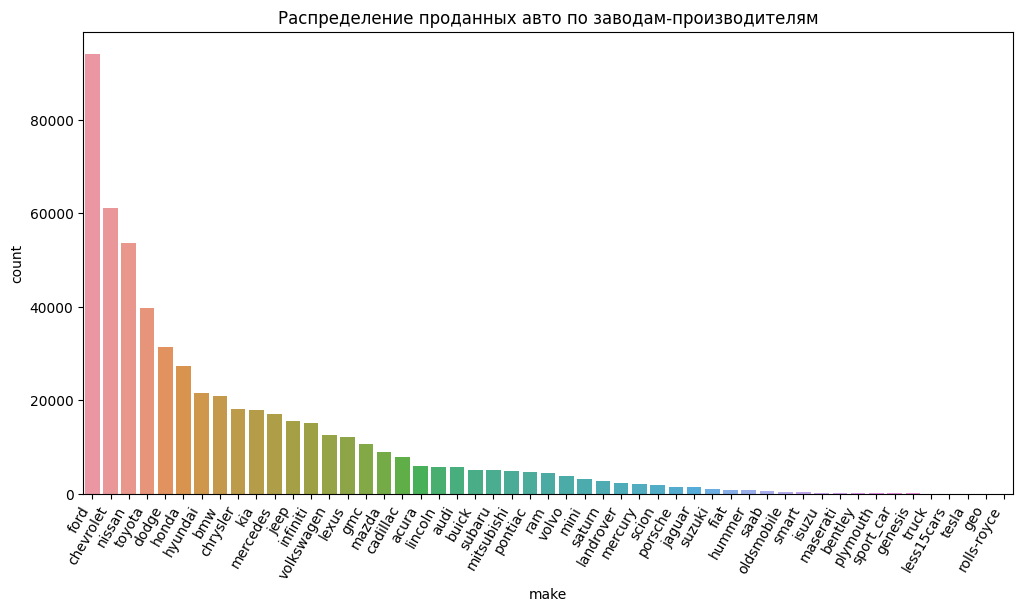

ford           94111
chevrolet      61010
nissan         53568
toyota         39705
dodge          31351
               ...  
truck             44
less15cars        24
tesla             23
geo               19
rolls-royce       17
Name: make, Length: 51, dtype: int64


In [19]:
category_priznak('make', [15],
                "Распределение проданных авто по заводам-производителям")

In [20]:
# Выведем список значений
display(data.make.unique())

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'toyota', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes', 'volkswagen', 'mazda', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'scion', 'fiat', 'suzuki', 'landrover', 'volvo', 'audi',
       'less15cars', 'mini', 'isuzu', 'truck', 'mitsubishi', 'smart',
       'porsche', 'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley',
       'maserati', 'genesis', 'tesla', 'rolls-royce', 'sport_car',
       'plymouth', 'geo'], dtype=object)

Оставляем такое распределение

#### Признак `model` - марка автомобиля.

In [21]:
# Количество пропущенных значений
print(data.model.isnull().sum())

# Приведем все записи 'make' к нижнему регистру.
data.model = data.model.str.lower()

# Выведем список значений
display(data.model.unique())

10196


array(['edge', 'fusion', 'sentra', 'h2', 'mkz', 'g6', 'escape', 'elantra',
       'freestyle', nan, 'lucerne', 'windstar', 'silverado 1500',
       'murano', 'equinox', 'accord', 'civic', 'mdx', 'cts', 'taurus',
       'srx', 'yukon', '9-3', 'explorer', 'f-150', 'charger', 'armada',
       'gl-class', 'avalon', 'tahoe', 'malibu', 'passat', 'camry', 'flex',
       '3 series', 'q50', 'altima', 'mustang', '300', 'sonata',
       'envoy xl', 'rogue', 'accent', 'maxima', 'forte', 'xf', 'outback',
       'grand caravan', 'e-class', 'cherokee', 'impala', 'optima',
       '5 series', 'expedition', 'is 250', 'mks', '200', 'veloster',
       'golf', 'rav4', 'e300dt', 'five hundred', 'g coupe',
       'grand cherokee', 'x-type', 'g convertible', 'tacoma', 'xa',
       'g sedan', 'tl', 'liberty', 'soul', '500l', 'town and country',
       'hhr', 'wrangler', 'reno', 'suburban', 'pt cruiser', 'gx 460',
       'sienna', 'sl-class', 'envoy', 'patriot', 'e-series van', 'versa',
       'aspen', 'm', 'co

**Отмечаем**:

1. Пропущенных значений в признаке *model* много, 10196.
2. Заменим попуски информацией из vin. Все производители шифруют свои модели в 5 и 6 символах vin.
3. Оставшимся пропущенными значениям присвоим `unknown`.

In [22]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 550294 │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 16     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA       ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75    ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ year             │        0 │       0 │    2000 │       4 │   2000 │    2000 │   2000 │      2000 │    ▁▃█ │  │
│ │ condition        │    12000 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │    4.2 │         5 │  ▄▄▅█▅ │  │
│ │ odometer         │       88 │   0.016 │   68000 │   54000 │      1 │   28000 │  99000 │   1000000 │   █    │  │
│ │ sellingprice     │   110000 │      20 │   14000 │    9800 │      1 │    6900 │  18000 │    230000 │   █    │  │
│ └──────────────────┴──────────┴─────────┴─────────┴─────────┴────────┴─────────┴────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │            0 │          0 │                          1 │                550000 │  │
│ │ model                     │        10000 │        1.9 │                          1 │                550000 │  │
│ │ trim                      │        10000 │        1.9 │                          1 │                550000 │  │
│ │ body                      │        13000 │        2.4 │                          1 │                550000 │  │
│ │ transmission              │        64000 │         12 │                          1 │                550000 │  │
│ │ vin                       │            0 │          0 │                          1 │                550000 │  │
│ │ state                     │            0 │          0 │                          1 │                550000 │  │
│ │ color                     │          740 │       0.14 │                          1 │                550000 │  │
│ │ interior                  │          740 │       0.14 │                          1 │                550000 │  │
│ │ seller                    │            0 │          0 │                          1 │                550000 │  │
│ │ saledate                  │            0 │          0 │                          1 │                550000 │  │
│ │ country                   │            0 │          0 │                          1 │                550000 │  │
│ └───────────────────────────┴──────────────┴──────────

Построим вспомогательную функцию для заполнения пустых значений по 5 и 6 значениям vin.

In [23]:
list_for_change = ['model', 'trim', 'body', 'transmission']
# Уберём ['color', 'interior', 'odometer']

def update_model(row):
    '''
    Функция ввода значения 'model' из vin вместо пустых значений и
    значений признаков из списка 'list_for_change' как наиболее частых
    для комбинации производитель-модель авто.
    '''   
    if pd.isnull(row['model']):             
        # Создаем временный датасет с годом и производителем
        df_tmp = data[(data.year == row.year) & \
                 (data.make == row.make)]
        row_index = np.where(data.vin == row.vin)[0][0]
        df_tmp = df_tmp.drop(index = row_index)
        df_tmp.reset_index(inplace = True)

        # Находим индекс изменяемого объекта
        row_index = np.where(data.vin == row.vin)[0][0]
        # Находим 5-6 символы vim - модель
        tmp_vin_num  = data.iloc[row_index].vin[5:7]

        for n in range(df_tmp.shape[0]):
            vin_num = df_tmp.loc[n].vin
            if( tmp_vin_num == vin_num[5:7] ):               
                if( (pd.isna(row.model) | (row.model == df_tmp.iloc[n].model) ) &                   
                    (pd.isna(row.trim) | (row.trim == df_tmp.iloc[n].trim) ) &
                    (pd.isna(row.body) | (row.body == df_tmp.iloc[n].body) ) &
                    (pd.isna(row.transmission) | 
                     (row.transmission == df_tmp.iloc[n].transmission) )
                  ): 
                    for pr in list_for_change:
                        cell = df_tmp.iloc[n][pr]
                        if( pd.notnull(cell)):
                            row[pr] = df_tmp.mode()[pr][0]              
                    return row
    return row

Заполним пустые значения в соответствии с информацией по 5 и 6 символам vin.

In [24]:
start = time.time()      
moscow_time = datetime.now(pytz.timezone(LOCAL_TIME_ZONE) ) 
print("Заполние пустых значений в соответствии с информацией",
      "по 5-6 символам vin началось в",
       moscow_time.strftime("%H:%M:%S"))

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    data = data.apply(update_model, axis=1)
    
    skim(data)

Заполние пустых значений в соответствии с информацией по 5-6 символам vin началось в 14:49:09


  0%|          | 0/1 [00:00<?, ?it/s]

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 550294 │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 16     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA       ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75    ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ year             │        0 │       0 │    2000 │       4 │   2000 │    2000 │   2000 │      2000 │    ▁▃█ │  │
│ │ condition        │    12000 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │    4.2 │         5 │  ▄▄▅█▅ │  │
│ │ odometer         │       88 │   0.016 │   68000 │   54000 │      1 │   28000 │  99000 │   1000000 │   █    │  │
│ │ sellingprice     │   110000 │      20 │   14000 │    9800 │      1 │    6900 │  18000 │    230000 │   █    │  │
│ └──────────────────┴──────────┴─────────┴─────────┴─────────┴────────┴─────────┴────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │            0 │          0 │                          1 │                550000 │  │
│ │ model                     │         5600 │          1 │                          1 │                550000 │  │
│ │ trim                      │         6100 │        1.1 │                          1 │                550000 │  │
│ │ body                      │         9700 │        1.8 │                          1 │                550000 │  │
│ │ transmission              │        63000 │         12 │                          1 │                550000 │  │
│ │ vin                       │            0 │          0 │                          1 │                550000 │  │
│ │ state                     │            0 │          0 │                          1 │                550000 │  │
│ │ color                     │          740 │       0.14 │                          1 │                550000 │  │
│ │ interior                  │          740 │       0.14 │                          1 │                550000 │  │
│ │ seller                    │            0 │          0 │                          1 │                550000 │  │
│ │ saledate                  │            0 │          0 │                          1 │                550000 │  │
│ │ country                   │            0 │          0 │                          1 │                550000 │  │
│ └───────────────────────────┴──────────────┴──────────

**Отмечаем**, что заполнено довольно много пропусков. Но не все, пропущенные значения еще остались.

Заменим пропущенные значения `model` на 'unknown'

In [25]:
data.model = data.model.fillna('unknown') # Заменим на unknown

In [26]:
# Количество пропущенных значений
print(data.model.isnull().sum())
# Количество значений каждой модели
print(data['model'].value_counts())

0
altima      19235
f-150       14720
fusion      12820
camry       12557
escape      11749
            ...  
8 series        1
pt              1
comm            1
b2300           1
sidekick        1
Name: model, Length: 853, dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

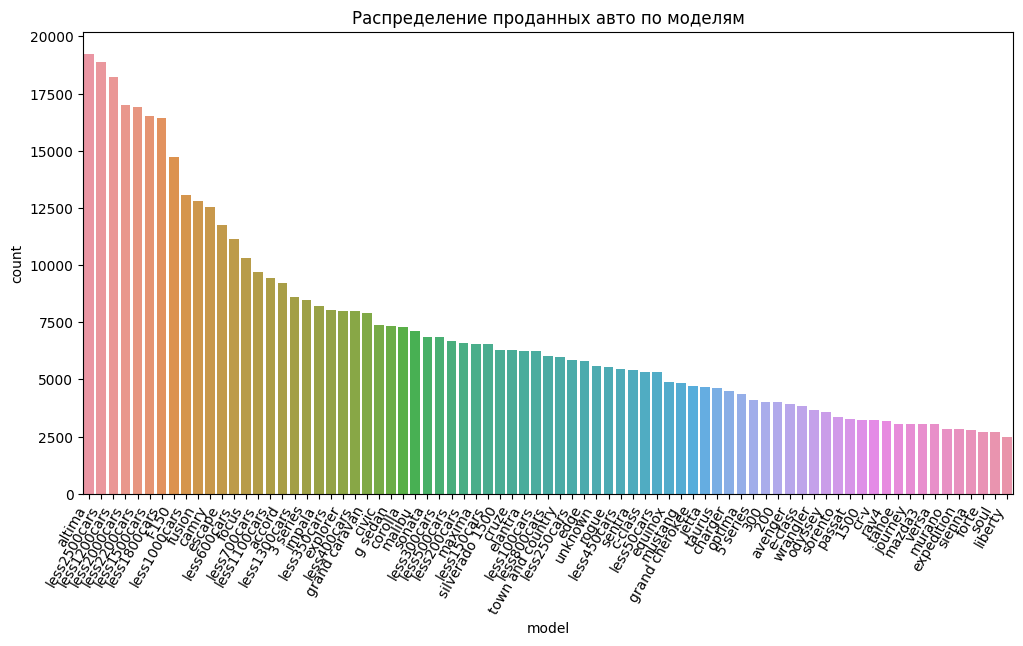

altima          19235
less2500cars    18892
less1200cars    18236
less2000cars    16982
less2200cars    16896
                ...  
expedition       2816
sienna           2806
forte            2724
soul             2708
liberty          2504
Name: model, Length: 77, dtype: int64


In [27]:
category_priznak('model', 
                 [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 
                  600, 700, 800, 1000, 1100, 1200, 1300, 1500, 1800,
                  2000, 2200, 2500],
                "Распределение проданных авто по моделям")

In [28]:
# Выведем список значений
display(data.model.unique())

array(['edge', 'fusion', 'sentra', 'less300cars', 'less1800cars',
       'escape', 'elantra', 'camry', 'less500cars', 'less250cars',
       'silverado 1500', 'murano', 'equinox', 'accord', 'civic',
       'less2200cars', 'taurus', 'less1500cars', 'less350cars',
       'explorer', 'f-150', 'charger', 'less800cars', 'less1100cars',
       'less1200cars', 'tahoe', 'malibu', 'passat', 'unknown', '3 series',
       'less600cars', 'altima', 'mustang', '300', 'sonata', 'rogue',
       'maxima', 'forte', 'impala', 'less400cars', 'grand caravan',
       'e-class', 'less700cars', 'optima', '5 series', 'expedition',
       'less2000cars', 'less1000cars', '200', 'rav4', 'less50cars',
       'grand cherokee', 'less200cars', 'g sedan', 'liberty', 'soul',
       'town and country', 'wrangler', 'less2500cars', 'less1300cars',
       'sienna', 'less450cars', 'versa', 'corolla', 'focus', 'sorento',
       'odyssey', 'less100cars', 'journey', 'jetta', 'avenger', 'cruze',
       'c-class', 'cr-v', 'less15

Оставляем такое распределение.

#### Признак `trim` - уровень отделки салона автомобиля.

In [29]:
# Количество пропущенных значений
print(data.trim.isnull().sum())

# Приведем все записи 'make' к нижнему регистру.
data.trim = data.trim.str.lower()

# Выведем список значений
display(data.trim.unique())

6095


array(['sel', 'se', '2.0 sl', ..., 'caravan le', 'signature l',
       'awd xs ll bean'], dtype=object)

Заменим пропущенные значения на `unknown`.

In [30]:
data.trim = data.trim.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550294 entries, 0 to 550293
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          550294 non-null  int64  
 1   make          550294 non-null  object 
 2   model         550294 non-null  object 
 3   trim          550294 non-null  object 
 4   body          540627 non-null  object 
 5   transmission  486867 non-null  object 
 6   vin           550294 non-null  object 
 7   state         550294 non-null  object 
 8   condition     538510 non-null  float64
 9   odometer      550206 non-null  float64
 10  color         549550 non-null  object 
 11  interior      549550 non-null  object 
 12  seller        550294 non-null  object 
 13  sellingprice  440236 non-null  float64
 14  saledate      550294 non-null  object 
 15  country       550294 non-null  object 
dtypes: float64(3), int64(1), object(12)
memory usage: 67.2+ MB


In [31]:
# Приведём к единому виду повторяющиеся названия компаний-производителей авто.
data.trim = data.trim.replace(
    {'c300 sport 4matic': 'c300 sport', 
     'e-350 super duty xlt': 'e350',
     'zx5 ses': 'zx5', 'zx5 se': 'zx5', 'zx5 premium': 'zx5',
     'zx4 ses': 'zx4', 'zx4 se': 'zx4', 'zx4 st': 'zx4',
     'zx3 ses': 'zx3', 'zx3 s': 'zx3', 'zx3 power premium': 'zx3',
     '& coun fwd lx': '& coun fwd', '& coun fwd limited': '& coun fwd',
    }
)
print(data.trim.unique())

# Количество каждого значения
print(data.groupby('trim').size())

['sel' 'se' '2.0 sl' ... 'caravan le' 'signature l' 'awd xs ll bean']
trim
!                451
& coun fwd        11
& country lx      15
(1999.5) xe        7
+               1612
                ... 
zx2 deluxe         7
zx3              146
zx4              408
zx5               87
zxw ses           26
Length: 1889, dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

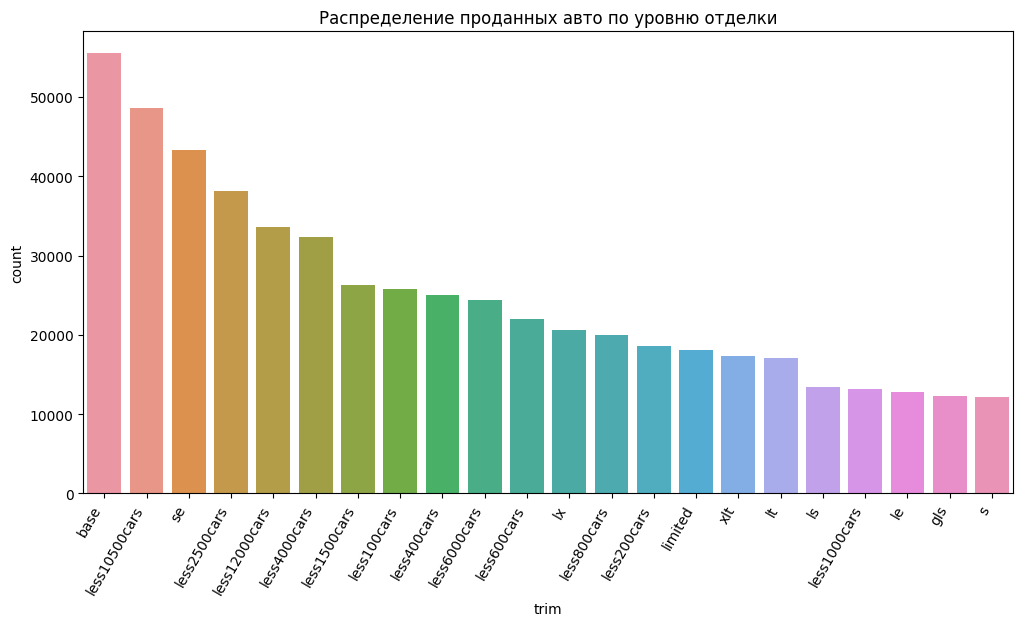

base             55477
less10500cars    48572
se               43284
less2500cars     38143
less12000cars    33555
less4000cars     32298
less1500cars     26286
less100cars      25724
less400cars      25071
less6000cars     24401
less600cars      21975
lx               20640
less800cars      19926
less200cars      18547
limited          18067
xlt              17291
lt               17134
ls               13472
less1000cars     13173
le               12841
gls              12282
s                12135
Name: trim, dtype: int64


In [32]:
category_priznak('trim', 
                 [100, 200, 400, 600, 800, 1000, 1500, 2500, 4000, 6000, 10500, 12000],
                "Распределение проданных авто по уровню отделки")

Хорошо. Оставим такой разброс.

#### Признак `body` - тип кузова транспортного средства

In [33]:
# Приведем все записи 'make' к нижнему регистру.
data.body = data.body.str.lower()

# Выведем список значений
display(data.body.unique())

# Посмотрим количество пропущенных значений
display(data.body.isnull().sum())

array(['suv', 'sedan', nan, 'wagon', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g convertible', 'access cab',
       'g sedan', 'e-series van', 'quad cab', 'tsx sport wagon', 'van',
       'cts coupe', 'koup', 'king cab', 'double cab', 'elantra coupe',
       'crewmax cab', 'genesis coupe', 'g37 coupe', 'club cab',
       'beetle convertible', 'mega cab', 'regular-cab', 'xtracab',
       'q60 coupe', 'promaster cargo van', 'cts-v coupe', 'cts wagon',
       'opentop', 'cab plus 4', 'g37 convertible', 'transit van',
       'q60 convertible', 'cab plus', 'ram van',
       'granturismo convertible', 'cts-v wagon'], dtype=object)

9667

In [34]:
data.body = data.body.fillna('unknown') # Заменим на unknown

In [35]:
# Приведём к единому виду повторяющиеся названия компаний-производителей авто.
data.body = data.body.replace(
    {'extended cab': 'cab', 'crew cab': 'cab',    'supercab': 'cab',
     'access cab': 'cab',   'quad cab': 'cab',    'king cab': 'cab',
     'double cab': 'cab',   'crewmax cab': 'cab', 'club cab': 'cab',
     'mega cab': 'cab',     'regular-cab': 'cab', 'xtracab': 'cab',
     'cab plus 4': 'cab',   'cab plus': 'cab',    'regular cab': 'cab',
     'g coupe': 'coupe',    'cts coupe': 'coupe', 'koup': 'coupe',
     'elantra coupe': 'coupe', 'genesis coupe': 'coupe',
     'q60 coupe': 'coupe',  'cts-v coupe': 'coupe','g37 coupe': 'coupe',
     'g convertible': 'convertible',   
     'beetle convertible': 'convertible', 
     'g37 convertible': 'convertible',
     'q60 convertible': 'convertible',
     'granturismo convertible': 'convertible',
     'g sedan': 'sedan',  'tsx sport wagon': 'wagon', 
     'cts wagon': 'wagon','cts-v wagon': 'wagon', 
     'e-series van': 'van', 'promaster cargo van': 'van', 
     'transit van': 'van',  'ram van': 'van', 
     'opentop': 'supercrew'
    }
)

In [36]:
print(data.body.value_counts())

sedan          247617
suv            142305
cab             37750
hatchback       25873
minivan         25253
coupe           19802
wagon           15951
convertible     10707
unknown          9667
supercrew        9012
van              6357
Name: body, dtype: int64


Хорошо. Оставим такой разброс.

#### Признак `transmission` - тип коробки передач.

In [37]:
print(data['transmission'].value_counts())

automatic    470160
manual        16707
Name: transmission, dtype: int64


In [38]:
# Количество каждого из значений коробки передач
data.groupby('transmission').size()

transmission
automatic    470160
manual        16707
dtype: int64

Таким образом, доля авто с автоматической коробкой составляет около 3,5%

In [39]:
# Посмотрим количество пропущенных значений
tr_null = data.transmission.isnull().sum()
tr_null

63427

In [40]:
data['transmission'] = data['transmission'].fillna(pd.Series(
    np.random.randint(0, 100, size=len(data)), index=data.index))

data['transmission'] = data['transmission'].replace('manual', 0)
data['transmission'] = data['transmission'].replace('automatic', 1)
data['transmission'] = data['transmission'].astype(int)

data['transmission'].mask(data['transmission'] > 97, 0, inplace=True)
data['transmission'].mask(data['transmission'] >= 2, 1, inplace=True)

print(data['transmission'].value_counts())

1    531630
0     18664
Name: transmission, dtype: int64


**Отмечаем**, что после заполнения пропущенных значений признака 'transmission'
итоговое распределение значений коробки передач осталось в той же пропорции:
96.5% - автоматическая коробка передач, 3.5% - ручная. 

#### Признак `state` - состояние, в котором автомобиль выставлен на аукцион.

In [41]:
# Выведем список значений
display(data.state.unique())

array(['md', 'mo', 'nj', 'tx', 'mi', 'nc', 'fl', 'oh', 'ca', 'az', 'ga',
       'tn', 'in', 'pa', 'va', 'wi', 'co', 'ny', 'il', 'nv', 'mn', 'wa',
       'sc', 'la', 'ne', 'ok', 'or', 'on', 'ma', 'ab', 'pr', 'hi', 'ut',
       'qc', 'ms', 'nm', 'ns', 'al'], dtype=object)

**Отмечаем**, что пропусков в признаке 'state' нет, а значения не требуются корректировке.

#### Признаки `color` - цвет кузова автомобиля и `interior` - цвет салона автомобиля.

In [42]:
# Выведем список значений
display(data.color.unique())
# Количество пропущенных значений
display(data.color.isnull().sum())

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', nan, 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

744

In [43]:
# Выведем список значений
display(data.interior.unique())
# Количество пропущенных значений
display(data.interior.isnull().sum())

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

744

**Отмечаем**:
1. У обоих признаков одинаковое количество пропусков: 724.
2. Пропуки присутствуют у одних и тех же объектов, т.е. при составлении базы данных не указывали равным образом и цвет автомобиля, и цает салона.
3. В обоих признаках есть незаполненные значения, отмеченные тире. Оставим их как, есть. И пропущенные значения тоже пометим тире.

In [44]:
#data = data.dropna(subset=['color'])
data.color = data.color.fillna('—') # Заменим пропусками
data.interior = data.interior.fillna('—') # Заменим пропусками

# Проверим количество пропущенных значений:
display(data.color.isnull().sum())
display(data.interior.isnull().sum())

0

0

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550294 entries, 0 to 550293
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          550294 non-null  int64  
 1   make          550294 non-null  object 
 2   model         550294 non-null  object 
 3   trim          550294 non-null  object 
 4   body          550294 non-null  object 
 5   transmission  550294 non-null  int32  
 6   vin           550294 non-null  object 
 7   state         550294 non-null  object 
 8   condition     538510 non-null  float64
 9   odometer      550206 non-null  float64
 10  color         550294 non-null  object 
 11  interior      550294 non-null  object 
 12  seller        550294 non-null  object 
 13  sellingprice  440236 non-null  float64
 14  saledate      550294 non-null  object 
 15  country       550294 non-null  object 
dtypes: float64(3), int32(1), int64(1), object(11)
memory usage: 65.1+ MB


#### Признак `seller` - продавец автомобиля, автосалоны.

In [46]:
# Выведем список значений
display(data.seller.unique())
# Количество пропущенных значений
display(data.seller.isnull().sum())

print(data.seller.value_counts())

array(['santander consumer', 'ars/avis budget group',
       'nissan-infiniti lt', ..., 'j t philips auto',
       'hadad auto whole sale', 'irwin auto company inc'], dtype=object)

0

nissan-infiniti lt               19675
ford motor credit company,llc    19134
the hertz corporation            18284
santander consumer               15273
avis corporation                 12528
                                 ...  
divinerstyles automotives llc        1
mnm auto                             1
tom wood ford inc                    1
bk motor sports llc                  1
irwin auto company inc               1
Name: seller, Length: 14093, dtype: int64


In [47]:
# Приведём к единому виду повторяющиеся названия компаний-производителей авто.
data.trim = data.trim.replace(
    {'nissan-infinity': 'nissan infinity'
    }
)

# Почистим названия компаний
def del_end_str(row):
    '''
    Удаление общепринятых окончаний названий компаний
    '''
    delete_end = ['capital & leasing', 'corporation', 'corp', 'sales',
                  'credit company,llc',  'company', ',llc', 'llc', 
                  'auto company inc', 'inc', 'lt', 'ltee', 'budget group', 
                  'credit', 'auto sales', 'automotives', 'consumer', 
                  'financial services', 'services', 'financial', 'finance', 
                  'north america inc.', ' motor credit company,llc pd',
                  ' motor sales usa inc/program',
                  'motor acceptance', 'motors america', 'motors', 'motor',
                  'corporation/gdp', 'credit company, llc pd', ',', ' ']
    row_tmp = row['seller']
    
    for s_end in delete_end:
        if (len(row_tmp) > len(s_end)) & \
            (s_end == row_tmp[-len(s_end):]):
            return(row_tmp[:-len(s_end)])
    return(row_tmp)

def the_str(row):            
    '''
    Удаление артикля 'the'
    '''
    delete_begin = ['the ']
    row_tmp = row['seller']
    for b_end in delete_begin:
        if (len(row_tmp) > len(b_end)) & (b_end == row_tmp[:len(b_end)]):
            return(row_tmp[len(b_end):])     
    return(row_tmp)

In [48]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    for n in range(5):
        data['seller'] = data.apply(del_end_str, axis=1)

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    data['seller'] = data.apply(the_str, axis=1)

print(data.seller.value_counts())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

ford                                           23399
hertz                                          20921
nissan-infiniti                                19675
avis                                           17166
santander                                      15275
                                               ...  
houston direct auto inc.                           1
santa fe autoplex                                  1
n-baro auction team wholesale motor vehicle        1
d&s brothers auto                                  1
irwin                                              1
Name: seller, Length: 13731, dtype: int64


In [49]:
def uni_seller(row):
    '''Унификация продавцов.'''
    company = ['hertz', 'avis', 'ford', 'nissan', 'toyota', 'kia', 
               'hyundai', 'chrysler', 'mercedes-benz', 'audi', 
               'bmv', 'gm', 'lexus', 'subaru', 'honda', 'vm']
    for name in company:
        if name in row['seller']:
            return name
    return row['seller']

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    data['seller'] = data.apply(uni_seller, axis=1)

    # Выведем список значений 
    print(data.seller.unique())

  0%|          | 0/1 [00:00<?, ?it/s]

['santander' 'avis' 'nissan' ... 'j t philips auto'
 'hadad auto whole sale' 'irwin']


  0%|          | 0/1 [00:00<?, ?it/s]

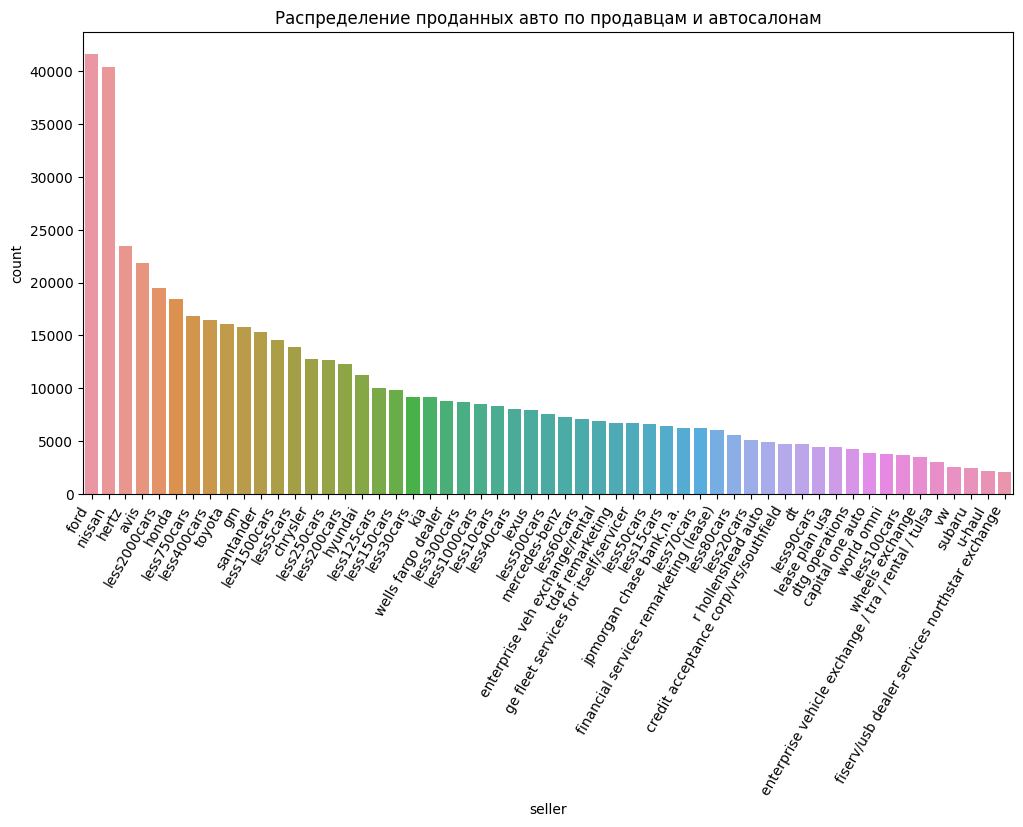

ford                                                  41639
nissan                                                40400
hertz                                                 23491
avis                                                  21846
less2000cars                                          19498
                                                      ...  
enterprise vehicle exchange / tra / rental / tulsa     3004
vw                                                     2520
subaru                                                 2446
u-haul                                                 2169
fiserv/usb dealer services northstar exchange          2032
Name: seller, Length: 55, dtype: int64


In [50]:
category_priznak('seller',
                 [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                  125, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000],
                 "Распределение проданных авто по продавцам и автосалонам")

**Отмечаем**, что значений в признаке `seller` много, около 14 тысяч. Поэтому обобщил их по категориям. 

### Рассмотрим количественные признаки.

In [51]:
# Описание количественных признаков:
data.describe()

,year,transmission,condition,odometer,sellingprice
count,550294.0,550294.0,538510.0,550206.0,440236.0
mean,2010.0,1.0,3.4,68290.4,13592.2
std,4.0,0.2,1.0,53538.0,9751.5
min,1982.0,0.0,1.0,1.0,1.0
25%,2007.0,1.0,2.7,28267.0,6900.0
50%,2012.0,1.0,3.6,52061.0,12100.0
75%,2013.0,1.0,4.2,99197.0,18200.0
max,2015.0,1.0,5.0,999999.0,230000.0


**Промежуточные выводы:**

1. Нет отрицательных численных значений.
2. Есть большой разброс в количественных значениях для различных признаков:
    * `year` от  1989 до 2015,
    * `condition` от 1 дол 5,
    * `odometer ` от 1 до 1_000_000.
    *  по целевому признаку `sellingprice` разброс тоже велик:  от 1 до 230_000. 
3. Для признака `odometer` отмечаем большую разницу между средним и медианным значениями, что говорит о наличии аномально высоких и низких значений.
3. Для целевого признака `sellingprice` тоже наблюдаем большую разницу между средним и медианным значениями, что тоже говорит о наличии аномально высоких и низких значений.

Рассмотрим количественные признаки подробнее.

#### Признак `year` - год выпуска автомобиля.

Посмотрим, как менялось количество проданных автомобилей по годам.

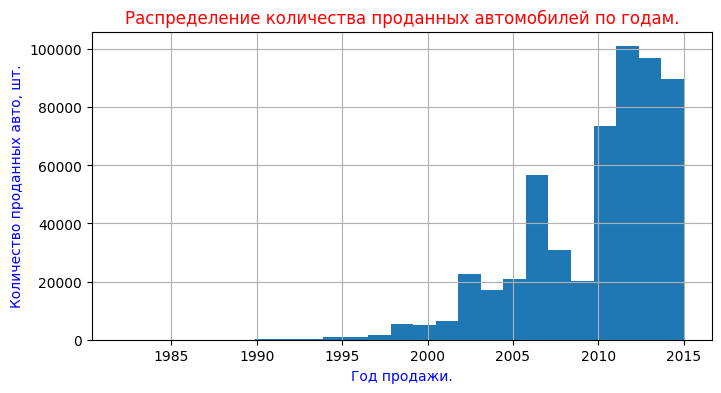

In [52]:
data.year.plot(kind = 'hist', bins = 25, grid = True, figsize = (8, 4));
plt.title('Распределение количества проданных автомобилей по годам.', color = 'red')
plt.xlabel('Год продажи.', color = 'blue')
plt.ylabel('Количество проданных авто, шт.', color = 'blue')
plt.show()

**Отмечаем**, что количество проданных авто растет с каждым годом. Исключение - экономический кризис 2008 года.

#### Признак `condition` - состояние автомобилей на момент аукциона.

In [53]:
# Посмотрим, какие значения оценки состояния 
# были даны автомобилям перед их продажей:
data.condition.value_counts()

1.9    41636
3.5    26249
3.7    25465
4.4    25123
4.3    24544
4.2    23976
3.6    22783
4.1    22660
2.0    20548
4.0    19718
3.9    19618
2.8    18876
2.9    18633
3.8    18454
3.4    17076
2.7    16072
4.9    12931
4.8    12561
4.6    12454
2.5    12344
4.5    12123
2.6    11693
4.7    11210
5.0    11080
3.0    10645
3.3    10435
3.2     9780
2.4     9158
3.1     9049
2.1     9042
2.3     8039
1.0     7323
2.2     5941
1.8      318
1.7      240
1.6      175
1.5      143
1.4      132
1.2       95
1.1       87
1.3       81
Name: condition, dtype: int64

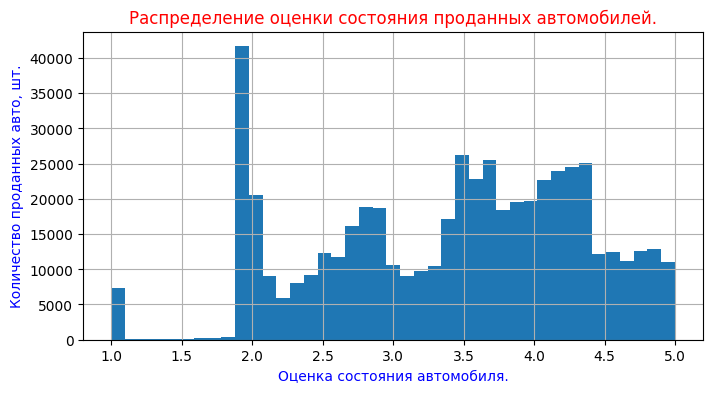

In [54]:
data.condition.plot(kind = 'hist', bins = 41, grid = True, figsize = (8, 4));
plt.title('Распределение оценки состояния проданных автомобилей.', color = 'red')
plt.xlabel('Оценка состояния автомобиля.', color = 'blue')
plt.ylabel('Количество проданных авто, шт.', color = 'blue')
plt.show()

In [55]:
# Посчитаем значений менее 1.5:
data.query('condition<1.5')['condition'].value_counts()

1.0    7323
1.4     132
1.2      95
1.1      87
1.3      81
Name: condition, dtype: int64

**Отмечаем**: 

1. Почти 7 тыс авто получили минимальную оценку состояния.
2. Нет ярко выраженного какого-то одного значения, все згачения оценок распределены в дипазоне от 1.0 до 5.0. Меnоды заполнения пропущенных значений max, min или mrdian тут не подходят.
3. Заполнение пропущенных 11.5 тысячи значений будем проводить рандомно.

In [56]:
# Проверим количество пропущенных значений:
display(data.condition.isnull().sum())

11784

In [57]:
data['condition'] = data['condition'].fillna(pd.Series(
    np.random.uniform(1, 5, size=len(data)), index=data.index))

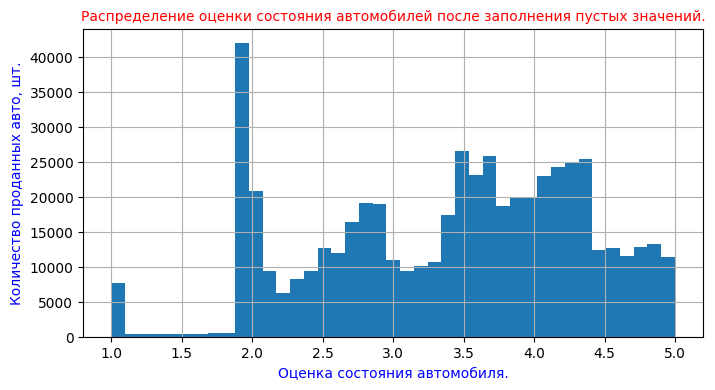

In [58]:
data.condition.plot(kind = 'hist', bins = 41, grid = True, figsize = (8, 4));
plt.title('Распределение оценки состояния автомобилей после заполнения пустых значений.',
          size = 10, color = 'red')
plt.xlabel('Оценка состояния автомобиля.', color = 'blue')
plt.ylabel('Количество проданных авто, шт.', color = 'blue')
plt.show()

#### Признак `odometer` - расстояние, пройденное автомобилем с момента выпуска.

In [59]:
# Проверим количество пропущенных значений:
display(data.odometer.isnull().sum())

88

**Отмечаем**:
    
1. Пропущенных значений пробега авто всего 88 из более, чем полумиллион записей.
2. Значение пробега считаем очень важным признаком для оценки стоимости авто, но просто удалить их не можем, т.к. изменится размер 'test' выборки.

In [60]:
data.loc[data['odometer'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,country
36557,2002,ford,less250cars,less100cars,minivan,1,2fmza51442ba27119,fl,2.1,NaN,beige,tan,less40cars,700.0,Wed Dec 17 2014 15:15:00 GMT-0800 (PST),Canada
42825,1997,toyota,camry,less800cars,sedan,1,4t1bg22k6vu171913,nj,4.1,NaN,gold,—,less10cars,1000.0,Wed Dec 17 2014 09:30:00 GMT-0800 (PST),USA
45516,2010,chevrolet,unknown,less10500cars,unknown,1,1gb6g3bg6a1146243,ny,1.6,NaN,white,gray,less20cars,4900.0,Thu Dec 18 2014 12:45:00 GMT-0800 (PST),USA
46266,2001,ford,mustang,less600cars,convertible,1,1fafp44481f128016,az,1.6,NaN,white,—,honda,500.0,Wed Dec 17 2014 13:30:00 GMT-0800 (PST),USA
60990,2014,ford,less2500cars,less1500cars,hatchback,0,3fadp4gx4em185929,ga,4.6,NaN,black,black,less750cars,28650.0,Tue Mar 24 2015 02:30:00 GMT-0700 (PDT),Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517294,2003,honda,accord,less10500cars,sedan,1,jhmcm56623c029673,il,3.5,NaN,beige,—,less15cars,NaN,Thu Dec 18 2014 10:00:00 GMT-0800 (PST),Japan
525873,2006,ford,f-150,xlt,cab,1,1ftrf12w26na75761,la,4.9,NaN,red,—,less40cars,NaN,Thu Dec 18 2014 11:00:00 GMT-0800 (PST),USA
533077,1998,infiniti,less100cars,base,suv,1,jnrar05y4ww025949,oh,3.1,NaN,white,tan,less60cars,NaN,Thu Dec 18 2014 09:00:00 GMT-0800 (PST),Japan
541399,2003,volvo,less200cars,base,wagon,1,yv1sz59h931104323,oh,4.6,NaN,blue,tan,less5cars,NaN,Tue Dec 23 2014 09:30:00 GMT-0800 (PST),Sweden


In [61]:
#data = data.dropna(subset=['odometer'])
data.odometer = data.odometer.fillna(1) # заменим единичками

#### Изучим аномальные значения пробега автомобиля.

In [62]:
# Для изучения присутствия аномальных значений  
# построим диаграмму размаха, или 'ящик с усами"

box_mustache_info = {    
     'odometer': 
     ['Распределение по пробегу автомобиля.',
      'Пробег, млн миль.'],      
           
    'sellingprice': 
     ['Распределение по продажной стоимости автомобиля.', 
      'Цена автомобиля.'],     
    }

def box_mustache(column_name):

    data.boxplot(column=column_name, figsize=(6, 5))
    plt.title(box_mustache_info[column_name][0], color = 'blue')
    plt.ylabel(box_mustache_info[column_name][1], color = 'blue')
    plt.show()

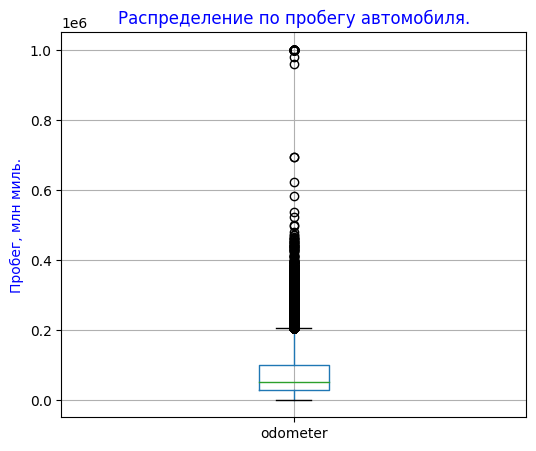

In [63]:
# Изучим присутствие аномальных значений, 
# построив диаграмму размаха, или 'ящик с усами"
box_mustache('odometer') 

In [64]:
# Посмотрим значения цены ниже 150:
data.query('odometer>990000')['odometer']

6069     999999.0
11122    999999.0
12368    999999.0
14897    999999.0
26602    999999.0
           ...   
511088   999999.0
526391   999999.0
530028   999999.0
530487   999999.0
548947   999999.0
Name: odometer, Length: 72, dtype: float64

In [65]:
data.query('odometer<10')['odometer']

125      1.0
212      1.0
270      1.0
696      7.0
788      1.0
          ..
549269   1.0
549383   1.0
549860   1.0
550044   1.0
550275   8.0
Name: odometer, Length: 1493, dtype: float64

**Отмечаем**:
    
* Наличие как больших, в районе 1 млн миль, так и крайне малых, даже менее 10 км значений пробега автомобиля.
* Например, значений пробега менее 10 км - 1320 штук, а менее 1000 миль - 2425 штук.
* Значений пробега на уровне 1 млн миль - 67 штук.

Видимо, это нормально. Вмешиваться нам нет причин.

#### Признак целевой `sellingprice` - продажная стоимость автомобиля.

Пропущенные значения стоимости авто принесены их тестового датасета, поэтому они понятны.

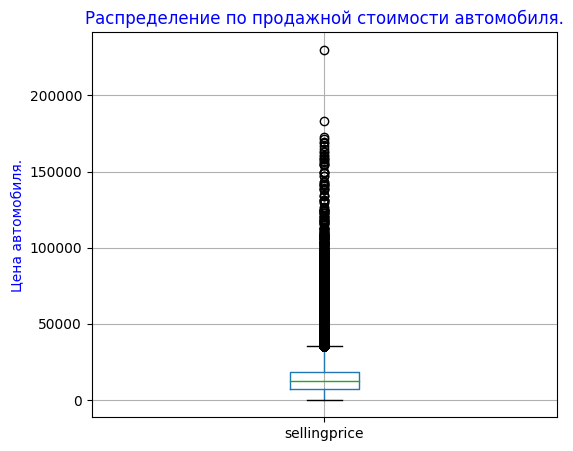

In [66]:
# Изучим присутствие аномальных значений, 
# построив диаграмму размаха, или 'ящик с усами"
box_mustache('sellingprice') 

### Создание новых синтетических признаков и удаление неинформативных.

In [67]:
def sale_year(row):
    '''Функция чтения года продажи авто.'''
    return row['saledate'].split()[3]

data['sale_year'] = data.apply(sale_year, axis=1)
data['sale_year'] = data['sale_year'].astype(int)
data['age'] = data['sale_year'] - data['year']
data.loc[data['age'] < 1, 'age'] = 1
data['age'] = data['age'].astype(int)

data['km_age'] = data['odometer'] / data['age'] 
data['cond_age'] = data['condition'] / data['age'] 
data['cond_km'] = data['condition'] / data['odometer'] 

# Удаление неинформативных признаков
data.drop('sale_year', axis= 1 , inplace= True ) # заменили на возраст - 'age'
data.drop('saledate', axis= 1 , inplace= True )
data.drop('year', axis= 1 , inplace= True )

display(data.head(2))

,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,country,age,km_age,cond_age,cond_km
0,ford,edge,less10500cars,suv,1,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander,12500.0,Canada,4,27760.2,1.1,0.0
1,ford,fusion,se,sedan,1,3fa6p0h75er208976,mo,3.5,31034.0,black,black,avis,14500.0,Mexico,1,31034.0,3.5,0.0


In [68]:
# Сохранение подготовленного датасета.
data.to_csv('data.csv', index=False, sep=',') 

In [69]:
# Загрузка ранее подготовленного датасета.
#if os.path.exists('data.csv'):
#    data = pd.read_csv('data.csv', sep=',')
#    print('Dataset', 'data.csv', 'is loaded successfully.')
#else:
#    print('Something with', 'data.csv', 'is wrong.')

# Промежуточные выводы после первичной обработки данных.

Для подготовки данных к последующей обработке были проведены следующие операции:

1. Загрузка файлов с данными.
2. Выяснили, что объем данных довольно большой: ~ 440 000 для обучающего датасета и ~ 110 000 для тестового.
3. Проверены категориальные признаки. Пустые значения заполнены или удалены.
4. Изучены количественные признаки. Аномальные значения оставлены без изменений.
5. Датасет не содержит пропусков в обучающих признаках и готов к дальнейшей работе.
7. Созданы новые синтетические признаки:
    * `month` - месяц продажи авто,
    * `age` - возраст автомобиля,
    * `km_year` - средний ежегодный пробег автомобиля, полный пробег/возраст,
    * `cond_year` - относительная оценка состояния автомобиля, оценка состояния/возраст.

# Предобработка данных (EDA - анализ).

## Разделим подготовленный датасет на рабочую и тестовую выборки. 

Критерий между ними - наличие и отсутствие целевого признака.

In [70]:
# Рабочая выборка:
data_train = data[data.sellingprice > 0]

# Удалим признак vin как неинформативный
data_train.drop('vin', axis= 1 , inplace= True )

data_train.info()
check_number_objects(data_train, initial_size_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440236 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          440236 non-null  object 
 1   model         440236 non-null  object 
 2   trim          440236 non-null  object 
 3   body          440236 non-null  object 
 4   transmission  440236 non-null  int32  
 5   state         440236 non-null  object 
 6   condition     440236 non-null  float64
 7   odometer      440236 non-null  float64
 8   color         440236 non-null  object 
 9   interior      440236 non-null  object 
 10  seller        440236 non-null  object 
 11  sellingprice  440236 non-null  float64
 12  country       440236 non-null  object 
 13  age           440236 non-null  int32  
 14  km_age        440236 non-null  float64
 15  cond_age      440236 non-null  float64
 16  cond_km       440236 non-null  float64
dtypes: float64(6), int32(2), object(9)
memory usage:

**Отмечаем**, что в обучающей выборке потерь нет.

In [71]:
# Тестовая выборка
test = data[data.isnull().any(axis=1)]

# сохраним признак vin для файла с результатами.
test_results = test[['vin']]

# Удалим признак vin как неинформативный
test.drop('vin', axis= 1 , inplace= True )

# Удалим целевой признак с отсутствующими значениями
test.drop('sellingprice', axis= 1 , inplace= True )

test.info()
check_number_objects(test, initial_size_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110058 entries, 440236 to 550293
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          110058 non-null  object 
 1   model         110058 non-null  object 
 2   trim          110058 non-null  object 
 3   body          110058 non-null  object 
 4   transmission  110058 non-null  int32  
 5   state         110058 non-null  object 
 6   condition     110058 non-null  float64
 7   odometer      110058 non-null  float64
 8   color         110058 non-null  object 
 9   interior      110058 non-null  object 
 10  seller        110058 non-null  object 
 11  country       110058 non-null  object 
 12  age           110058 non-null  int32  
 13  km_age        110058 non-null  float64
 14  cond_age      110058 non-null  float64
 15  cond_km       110058 non-null  float64
dtypes: float64(5), int32(2), object(9)
memory usage: 13.4+ MB
Количество объектов в изначал

**Отмечаем**, что в тестовой выборке потерь нет.

## Подготовим рабочий датасет к дальнейшей работе. 

### Разделим рабочий датасет на обучающую и тестовую выборки в пропорции 8:2.

In [72]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(
        data_train.drop('sellingprice', axis=1), 
        data_train['sellingprice'],
        train_size=0.8, 
        random_state=RANDOM_STATE_FIX)

In [73]:
print('Проверим данные после разбиения на выборки, нет ли потерь:')

if( data_train.shape[0] == (X_train.shape[0] + X_valid.shape[0])):
    print('  После разделения датасета в обучающей выборке потерь нет.')
else:
    print('ВНИМАНИЕ! Есть потеря данных в обучающей выборке.\n' \
          'Сумма количества объектов в обучающей выборке НЕ равно ' \
          'количеству объектов исходного датасета.')
    print(data_train.shape[0], X_train.shape[0] + X_valid.shape[0])
    
if( data_train.shape[0] == (y_train.shape[0] + y_valid.shape[0])):
    print('  После разделения датасета в тестовой выборке потерь нет.')
else:
    print('ВНИМАНИЕ! Есть потеря данных в тестовой выборке.\n' \
          'Сумма количества объектов в тестовой выборке НЕ равно ' \
          'количеству объектов исходного датасета.')
    print(data_train.shape[0], y_train.shape[0] + y_valid.shape[0])

Проверим данные после разбиения на выборки, нет ли потерь:
  После разделения датасета в обучающей выборке потерь нет.
  После разделения датасета в тестовой выборке потерь нет.


### Количественные признаки.

#### Изучим наши данные на мультиколлинеарность признаков.

Посмотрим взаимную корреляцию признаков датасета:

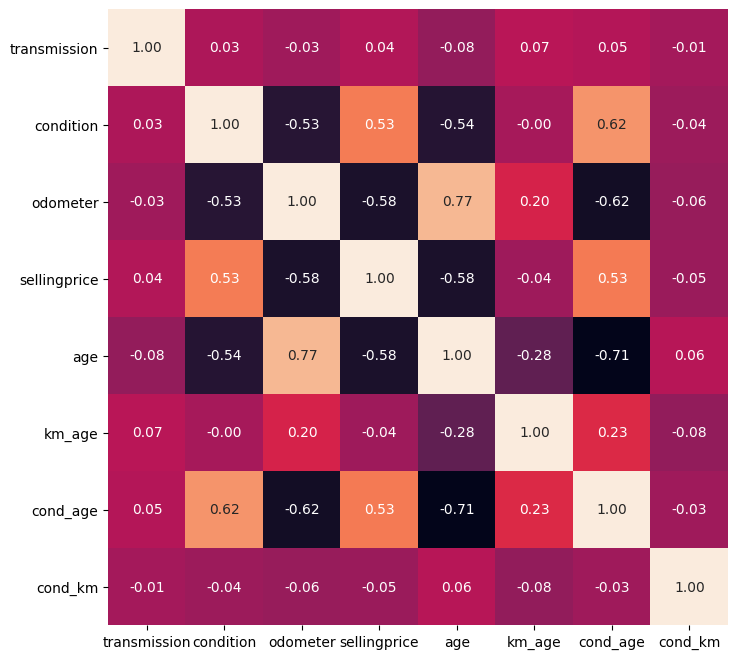

In [74]:
plt.figure(figsize=(8,8))
sns.heatmap(data_train.corr(), annot=True, annot_kws={"size":10}, fmt = '.2f', cbar=False)
plt.show()

**Отмечаем**, что очень сильных взаимосвязей (выше 0.8, тем более выше 0.9) между признаками нет.

#### Изучим зависимость количественных и целевого признаков.

In [75]:
def price_dependence(priznak, title):
    mean_price = data_train[[priznak, 'sellingprice']].groupby(priznak, \
                          as_index=False).mean().astype('int')
    plt.figure(figsize=(6,4))
    plt.grid(axis = 'both')
    sns.lineplot(x=priznak, y='sellingprice', data=mean_price)
    plt.xlabel(f'Признак "{priznak}"', color='blue')
    plt.ylabel('Средняя цена', color='blue')
    plt.title(title, color='blue', size=12)
    plt.show()  

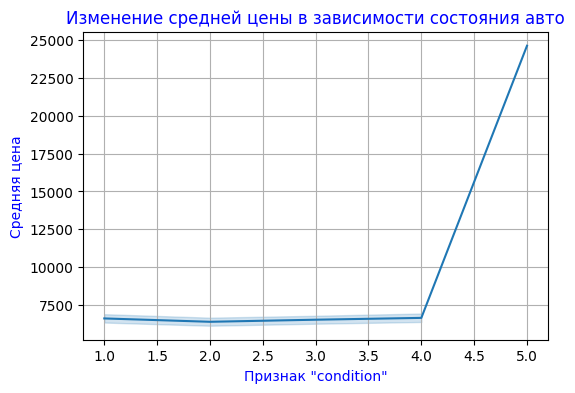

In [76]:
price_dependence('condition', \
                 'Изменение средней цены в зависимости состояния авто')

Отмечаем закономерность к резкому увеличению (в три раза) стоимости автомобиля, состояние которого оценено выше 4 баллов.

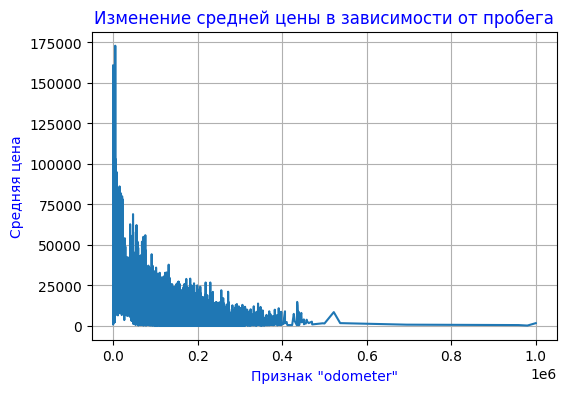

In [77]:
price_dependence('odometer', \
                 'Изменение средней цены в зависимости от пробега')

Тоже разумная закономерность. Авто с пробегом в несколько десятков тысяч миль еще в цене. А с увеличением пробега, стоимость авто резко падает в десятки раз.

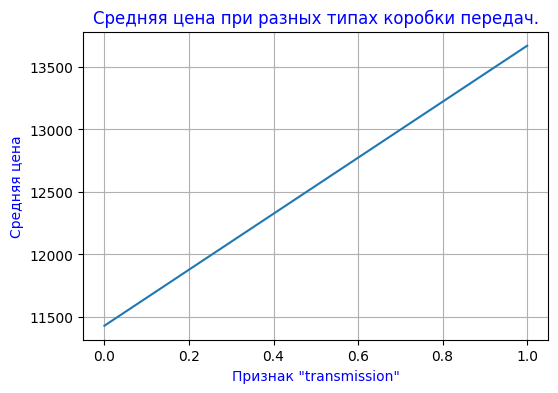

In [78]:
price_dependence('transmission', \
                 'Средняя цена при разных типах коробки передач.')

Интересно, что наличие автоматической коробки передач даёт повышение в цене в среднем на 20%.

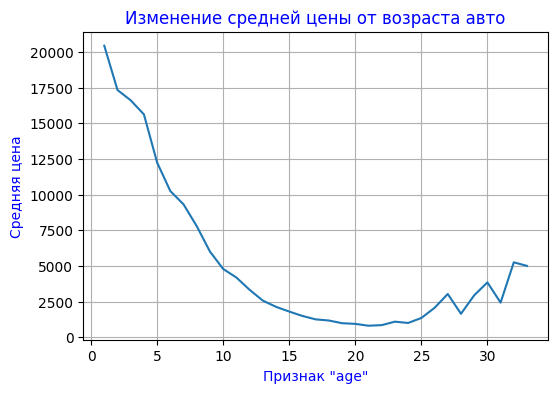

In [79]:
price_dependence('age', \
                 'Изменение средней цены от возраста авто')

Отмечаем, что стоимость автомобиля падает с возрастом на порядок. Автомобили, ставшие раритетными, растут в цене.

#### Масштабирование численных признаков .

Отмечаем, что у наших численных признаков сильно отличающийся масштаб. Есть значения даже в сотни тысяч.   
Чтобы при последующей обработке такие высокие цифры не воспринимались, как более важные признаки, проведем их к одному масштабу. 

In [80]:
# Создадим список из названий столбцов для масштабирования:
number_columns = X_train.select_dtypes(include=['number']).columns.tolist()
number_columns.remove('condition')
number_columns

['transmission', 'odometer', 'age', 'km_age', 'cond_age', 'cond_km']

In [81]:
# Преобразуем данные с помощью StandardScaler.

# Создадим объект структуры StandardScaler:
scaler = StandardScaler()
scaler.fit(X_train[number_columns]) 

X_train[number_columns] = scaler.transform(X_train[number_columns])  
X_valid[number_columns] = scaler.transform(X_valid[number_columns])
test[number_columns] = scaler.transform(test[number_columns])

### Категориальные признаки.

In [82]:
# выделим только категориальные признаки:
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print(cat_columns)

['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller', 'country']


#### Кодирование категориальных признаков.

Преобразуем категориальные признаки в численные для обучающей выборки.

In [83]:
# Создаём объект новой структуры данных:
encoder = OrdinalEncoder() 
encoder.fit(X_train[cat_columns])

X_train[cat_columns] = encoder.transform(X_train[cat_columns])  
X_valid[cat_columns] = encoder.transform(X_valid[cat_columns])
test[cat_columns] = encoder.transform(test[cat_columns])  

**Посмотрим X_train**:

In [84]:
X_train.describe()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,country,age,km_age,cond_age,cond_km
count,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0
mean,19.0,35.3,9.7,5.1,-0.0,16.2,3.4,-0.0,9.4,4.0,25.8,11.1,-0.0,0.0,0.0,-0.0
std,13.9,19.7,6.3,2.2,1.0,11.5,1.0,1.0,6.7,4.3,15.2,4.7,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,-5.3,0.0,1.0,-1.3,0.0,0.0,0.0,0.0,-1.0,-1.7,-1.1,-0.0
25%,8.0,20.0,5.0,5.0,0.2,5.0,2.7,-0.7,2.0,1.0,13.0,9.0,-0.7,-0.6,-0.8,-0.0
50%,14.0,36.0,9.0,5.0,0.2,14.0,3.6,-0.3,7.0,1.0,26.0,15.0,-0.5,-0.2,-0.3,-0.0
75%,30.0,49.0,15.0,7.0,0.2,28.0,4.2,0.6,15.0,6.0,39.0,15.0,0.5,0.4,0.4,-0.0
max,50.0,76.0,21.0,10.0,0.2,37.0,5.0,17.4,19.0,16.0,54.0,15.0,7.2,102.6,2.6,43.2


Создадим дополнительные синтетические признаки на основе кодированных категориальных признаках:

In [85]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):

    df = [X_train, X_valid, test]    
    for i in range(3):  
        df[i]['make_age'] = df[i]['make'] / df[i]['age']
        df[i]['make_country'] = df[i]['make'] / (df[i]['country']+1)
        df[i]['make_model'] = df[i]['make'] / (df[i]['model']+1)

        df[i]['model_age'] = df[i]['model'] / df[i]['age'] 
        df[i]['model_country'] = df[i]['model'] / (df[i]['country']+1)
        df[i]['model_make'] = df[i]['model'] / (df[i]['make']+1)

        df[i]['trim_age'] = df[i]['trim'] / df[i]['age']
        df[i]['trim_country'] = df[i]['trim'] / (df[i]['country']+1)
        df[i]['trim_make'] = df[i]['trim'] / (df[i]['make']+1)
        df[i]['trim_model'] = df[i]['trim'] / (df[i]['model']+1)
        df[i]['trim_body'] = df[i]['trim'] / (df[i]['body']+1)

        df[i]['body_age'] = df[i]['body'] / df[i]['age'] 
        df[i]['body_country'] = df[i]['body'] / (df[i]['country']+1)
        df[i]['body_make'] = df[i]['body'] / (df[i]['make']+1)
        df[i]['body_model'] = df[i]['body'] / (df[i]['model']+1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
X_train.describe()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,country,age,km_age,cond_age,cond_km,make_age,make_country,make_model,model_age,model_country,model_make,trim_age,trim_country,trim_make,trim_model,trim_body,body_age,body_country,body_make,body_model
count,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0,352188.0
mean,19.0,35.3,9.7,5.1,-0.0,16.2,3.4,-0.0,9.4,4.0,25.8,11.1,-0.0,0.0,0.0,-0.0,14.3,2.0,1.1,35.5,3.9,3.2,7.7,1.1,0.9,0.5,2.2,4.5,0.6,0.5,0.3
std,13.9,19.7,6.3,2.2,1.0,11.5,1.0,1.0,6.7,4.3,15.2,4.7,1.0,1.0,1.0,1.0,174.8,2.3,3.0,312.8,4.1,5.0,88.1,1.2,1.0,0.9,3.0,43.0,0.6,0.7,0.3
min,0.0,0.0,0.0,0.0,-5.3,0.0,1.0,-1.3,0.0,0.0,0.0,0.0,-1.0,-1.7,-1.1,-0.0,-221.3,0.0,0.0,-336.4,0.0,0.0,-93.0,0.0,0.0,0.0,0.0,-44.3,0.0,0.0,0.0
25%,8.0,20.0,5.0,5.0,0.2,5.0,2.7,-0.7,2.0,1.0,13.0,9.0,-0.7,-0.6,-0.8,-0.0,-32.3,0.6,0.2,-57.5,1.4,1.1,-18.7,0.4,0.2,0.1,0.8,-9.5,0.3,0.2,0.1
50%,14.0,36.0,9.0,5.0,0.2,14.0,3.6,-0.3,7.0,1.0,26.0,15.0,-0.5,-0.2,-0.3,-0.0,-10.1,1.5,0.5,-19.0,2.9,1.9,-6.1,0.8,0.6,0.3,1.5,-5.0,0.4,0.3,0.2
75%,30.0,49.0,15.0,7.0,0.2,28.0,4.2,0.6,15.0,6.0,39.0,15.0,0.5,0.4,0.4,-0.0,10.5,2.7,0.9,27.9,4.5,3.6,5.0,1.2,1.4,0.6,2.6,3.8,0.7,0.6,0.3
max,50.0,76.0,21.0,10.0,0.2,37.0,5.0,17.4,19.0,16.0,54.0,15.0,7.2,102.6,2.6,43.2,1730.0,35.0,48.0,2629.6,50.0,74.0,726.6,16.0,16.0,9.5,21.0,346.0,5.0,10.0,8.0


# Создание и обучение модели.

## Функция расчета метрики качества.

Для оценки качества моделей применяем метрику [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error "Mean Absolute Percentage Error"):
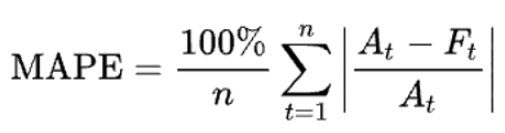

In [87]:
def mape_func(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape_score = make_scorer(mape_func, greater_is_better=False)
#mape_score = make_scorer(mape_func)

## Создание и обучение моделей.

### Вспомогательные функции.

In [88]:
# Датафрейм для сохранения результатов работы.
df_results = pd.DataFrame(columns=[
    'model', 'best_score', 'MAPE_train', 'MAPE_valid', 'fit time, c', 'fit time', 'parameters'])

# Сорварь с набором отработанных моделей.
dictionary_models = {}


# Функция для перевода секунд в часы, минуты...
def exec_time(diff_time):
    '''
    Перевод секунд в часы, минуты ...
    '''
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return ("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))


def model_fit_time_metrics(model, model_name, disp = True):
    '''
    Функция обучения модели, измерения времени обучения,
    расчёта метрик, сохранения результатов в датасет и 
    создания словаря из обученных моделей.
    '''   
    if model_name not in list(df_results['model']):  
        
        start = time.time()      
        moscow_time = datetime.now(pytz.timezone(LOCAL_TIME_ZONE) ) 
        print("The start of the fitting '",
              model_name, "' model in Moscow time: ", 
              moscow_time.strftime("%H:%M:%S"), sep='')

        model.fit(X_train, y_train)
        fit_time = time.time() - start
       
        mape_train = abs(mape_func(y_train, model.predict(X_train)))
        mape_valid = abs(mape_func(y_valid, model.predict(X_valid)))
       
        df_results.loc[len(df_results.index )] = \
            [model_name, 
             abs(model.best_score_), 
             mape_train, mape_valid, 
             round(fit_time, 1), exec_time(fit_time), 
             model.best_params_]
        
        dictionary_models[model_name] = model
        
        test_results['sellingprice'] =  model.predict(test)    
        test_results.reset_index(drop= True , inplace= True )
        test_results.to_csv('test_results_' + model_name + '.csv', sep=',', 
                            index=False, columns =['vin', 'sellingprice'])
        
        if( disp):    
            display(df_results)
    else:
        print(model_name, 'уже существует!')

### Линейные модели.

In [89]:
regressors = (
    (LinearRegression(), 
     {'fit_intercept':[True,False], 
      'normalize':[True,False], 
      'copy_X':[True, False]}
    ),
    (Ridge(), {'alpha': [500, 1000]}
    ),
    (Lasso(), {'alpha': [50, 100, 150]}
    ),
    (ElasticNet(), {'alpha': [0.2, 0.3, 0.4]}
    ),
    (DecisionTreeRegressor(random_state=RANDOM_STATE_FIX), 
     {'max_depth': [16]}
    ),
    )

disp = False
for n in tqdm(range(len(regressors))):
    model = regressors[n][0]
    parameters = regressors[n][1]
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring = mape_score,
                              cv = 5, 
                              n_jobs = -1,
                              verbose = 0)      
    
    if n == len(regressors)-1:
        disp = True
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__,
                          disp)

  0%|          | 0/5 [00:00<?, ?it/s]

The start of the fitting 'LinearRegression' model in Moscow time: 15:13:59
The start of the fitting 'Ridge' model in Moscow time: 15:14:21
The start of the fitting 'Lasso' model in Moscow time: 15:14:22
The start of the fitting 'ElasticNet' model in Moscow time: 15:14:38
The start of the fitting 'DecisionTreeRegressor' model in Moscow time: 15:15:00


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}


**Промежуточные выводы:**
    
Построены линейные модели с механизмом кросс-валидацией:
* `Линейная регрессия`.
* `Ridge` регрессия.
* `Lasso` регрессия.
* `ElasticNet` регрессия.
* Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

### Ансамблевые методы регрессии.

#### Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.

In [90]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth': range(17, 18), 
                  'n_estimators': range(459, 460)}
    
    model = RandomForestRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring=mape_score, 
                              cv=3,  
                              n_jobs=-1,
                              verbose=0)
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'RandomForestRegressor' model in Moscow time: 15:15:13


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"


#### Модель `HistGradientBoostingRegressor`  c подбором гиперпараметров GridSearchCV.

In [91]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
#    parameters = {'max_depth' : range(14, 15),
#                  'n_estimators': range(409, 410), 
#                  'learning_rate': [0.1] }
#    model = GradientBoostingRegressor(random_state=RANDOM_STATE_FIX)
    
    parameters = {'max_depth': [14],
                  'max_iter': [409], 
                  'learning_rate': [0.3],
                  'min_samples_leaf': [20],
                 }
    
    model = HistGradientBoostingRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring=mape_score,
                              cv=3,  
                              n_jobs=-1,
                              verbose=0)
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'HistGradientBoostingRegressor' model in Moscow time: 16:08:16


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
6,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"


**Промежуточные выводы:**

Построены две ансамблевые модели:
* Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.
* Модель `GradientBoostingRegressor`  c подбором гиперпараметров GridSearchCV.

### Итеративные модели.

#### Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.

In [92]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth': [14],
                  'n_estimators': [6000],
                  'learning_rate': [0.05]}

    model = LGBMRegressor(random_state=RANDOM_STATE_FIX, 
                          objective='regression')
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring = mape_score,
                              cv = 3,  
                              n_jobs = -1,
                              verbose = 0)
    
#scoring = make_scorer(mean_absolute_percentage_error,
#                 greater_is_better = False),
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'LGBMRegressor' model in Moscow time: 16:08:57


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
6,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"
7,LGBMRegressor,18.7,15.0,15.8,340.6,00:05:41,"{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 6000}"


#### Модель градиентного бустинга CatBoost c подбором гиперпараметров GridSearchCV.¶

In [93]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : [16],
                  'iterations': [363],
                  'verbose': [0]
                 }
    
    model = CatBoostRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring=mape_score,
                              cv=3,  
                              n_jobs=-1)
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'CatBoostRegressor' model in Moscow time: 16:15:43


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
6,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"
7,LGBMRegressor,18.7,15.0,15.8,340.6,00:05:41,"{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 6000}"
8,CatBoostRegressor,20.8,9.7,17.3,3643.6,01:00:44,"{'iterations': 363, 'max_depth': 16, 'verbose': 0}"


#### Модель градиентного бустинга `XGBoost` с использованием GridSearch.

In [94]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(26, 27),
                  'n_estimators': range(51, 52),
                 }
    
    model = xgb.XGBRFRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, 
                              param_grid = parameters, 
                              scoring=mape_score,
                              cv=3,  
                              n_jobs=-1,
                              verbose=0)
    
    model_fit_time_metrics(grid_model, 
                           model.__class__.__name__)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'XGBRFRegressor' model in Moscow time: 17:16:28


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LinearRegression,70.8,70.9,68.3,21.4,00:00:21,"{'copy_X': True, 'fit_intercept': True, 'normalize': False}"
1,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}
2,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
3,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
4,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
6,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"
7,LGBMRegressor,18.7,15.0,15.8,340.6,00:05:41,"{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 6000}"
8,CatBoostRegressor,20.8,9.7,17.3,3643.6,01:00:44,"{'iterations': 363, 'max_depth': 16, 'verbose': 0}"
9,XGBRFRegressor,22.8,4.8,17.5,448.4,00:07:28,"{'max_depth': 26, 'n_estimators': 51}"


### **Промежуточные выводы:**

Построены три итеративные модели:
* Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.
* Модель градиентного бустинга `XGBoost` с использованием GridSearch.

Отмечаем, что `CatBoostRegressor` и `XGBRFRegressor` сильно переобучены.

## Создание и обучение моделей на базе Pipeline.

In [95]:
%%time

start_time = time.time()

C_range = loguniform(1e-3, 1).rvs(10000, random_state=RANDOM_STATE_FIX).round(3)
estimators_range = uniform(1,500).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)
max_depth_range = uniform(1,20).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)

pipeline = make_imblearn_pipeline(RandomForestRegressor())
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

param_grid = [
    {   'linearregression': [LinearRegression()],
         'columntransformer__pipeline__standardscaler':
             [MinMaxScaler(), StandardScaler()],
    },
    
    {
        'clf': [DecisionTreeRegressor(random_state=RANDOM_STATE_FIX)],
        'clf__max_depth': max_depth_range
    },

    {
        'clf': [RandomForestRegressor(random_state=RANDOM_STATE_FIX)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [HistGradientBoostingRegressor(random_state=RANDOM_STATE_FIX, learning_rate=0.1)],
        'clf__max_iter': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [LGBMRegressor(random_state=RANDOM_STATE_FIX, learning_rate=0.1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
      
    {
        'clf': [CatBoostRegressor(random_state=RANDOM_STATE_FIX, verbose=0)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [xgb.XGBRFRegressor(random_state=RANDOM_STATE_FIX, eta=1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    }
]

Pipe_model = RandomizedSearchCV(pipeline,  
                                param_grid, 
                                n_iter=30,
                                cv=3, 
                                scoring=mape_score,
                                random_state=RANDOM_STATE_FIX,
                               )


# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    Pipe_model.fit(X_train, y_train)

time_pipe_working = time.time() - start_time    
print('Execiting time:', exec_time(time_pipe_working))

# Сохраним результаты расчета Pipeline с тестовыми данными в файл:
test_results['sellingprice'] = Pipe_model.predict(test)    
test_results.reset_index(drop= True , inplace= True )

test_results.to_csv('test_results_Pipe_model_model.csv', sep=',', 
                    index=False, columns =['vin', 'sellingprice'])

  0%|          | 0/1 [00:00<?, ?it/s]

Execiting time: 02:47:52
CPU times: total: 9h 49min 58s
Wall time: 2h 47min 52s


### Лучшая pipe - модель.

In [96]:
print("Значение MAPE на обучающей выборке Pipeline модели:", 
      round(abs(Pipe_model.best_score_), 2))
print('-' * 50)      
print("Значение MAPE на валидационной выборке Pipeline модели", 
      round(abs(Pipe_model.score(X_valid, y_valid)), 2))
print('-' * 50)      
print("Наилучшие параметры Pipeline модели:\n", Pipe_model.best_params_)

Значение MAPE на обучающей выборке Pipeline модели: 20.26
--------------------------------------------------
Значение MAPE на валидационной выборке Pipeline модели 16.86
--------------------------------------------------
Наилучшие параметры Pipeline модели:
 {'clf__n_estimators': 405, 'clf__max_depth': 13, 'clf': <catboost.core.CatBoostRegressor object at 0x0000019B300A4EB0>}


In [97]:
# Таблица с лучшими результатами

print("Наилучшие параметры pipe - модели:", round(Pipe_model.best_score_, 1))
cv_results = pd.DataFrame(Pipe_model.cv_results_)
cv_results = cv_results.sort_values("rank_test_score", ascending=True)
cv_results = cv_results.reset_index(drop=True)
cv_results[['mean_test_score', 'rank_test_score', 'params', ]].head(3)

Наилучшие параметры pipe - модели: -20.3


,mean_test_score,rank_test_score,params
0,-20.3,1,"{'clf__n_estimators': 405, 'clf__max_depth': 13, 'clf': <catboost.core.CatBoostRegressor object at 0x0000019B300A4EB0>}"
1,-20.8,2,"{'clf__n_estimators': 363, 'clf__max_depth': 16, 'clf': <catboost.core.CatBoostRegressor object at 0x0000019B300A4EB0>}"
2,-21.1,3,"{'clf__n_estimators': 214, 'clf__max_depth': 10, 'clf': <catboost.core.CatBoostRegressor object at 0x0000019B300A4EB0>}"


In [98]:
# Сформируем имя лучшей pipeline модели:

text = str(cv_results.params[0]['clf'])
try:
    found = re.search('(.+?)Regressor', text).group(1) + \
            'Regressor+Pipeline'
except AttributeError:
    found = ''

# Сформируем список параметров лучшей pipeline модели:
param_pipe = '{' + \
             'clf__n_estimators : ' + \
             str(cv_results.params[0]['clf__n_estimators']) + \
             ', clf__max_depth : ' + \
             str(cv_results.params[0]['clf__max_depth']) + \
            '}'


# Добавим модель, рассчитанную pipeline в наш список моделей:
if found not in list(df_results['model']):  
    df_results.loc[len(df_results.index )] = \
        [found, 
         abs(cv_results.mean_test_score[0]),
         abs(mape_func(y_train, Pipe_model.predict(X_train))),
         abs(mape_func(y_valid, Pipe_model.predict(X_valid))),
         round(cv_results.mean_fit_time[0], 1),
         exec_time(cv_results.mean_fit_time[0]),
         'Full time: ' + str(exec_time(time_pipe_working)) + ' ' + param_pipe 
        ]

    dictionary_models[found] = Pipe_model

**Промежуточные выводы:**
    
Построен конвейер `pipeline` для построения 7 моделей:
* `LinearRegression` - линейная модель.
* `DecisionTreeRegressor` - линейная модель.
* `RandomForestRegressor` - ансамблевая модель.
* `GradientBoostingRegressor` - ансамблевая модель.
* `LGBMRegressor` - итеративная модель градиентного бустинга.
* `CatBoostRegressor` - итеративная модель градиентного бустинга.
* `XGBRFRegressor` - итеративная модель градиентного бустинга.

В качестве лучшей определена `CatBoostRegressor`.

### Определим наилучшую модель.

,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,LGBMRegressor,18.7,15.0,15.8,340.6,00:05:41,"{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 6000}"
1,<catboost.core.CatBoostRegressor+Pipeline,20.3,14.4,16.9,166.9,00:02:47,"Full time: 02:47:52 {clf__n_estimators : 405, clf__max_depth : 13}"
2,CatBoostRegressor,20.8,9.7,17.3,3643.6,01:00:44,"{'iterations': 363, 'max_depth': 16, 'verbose': 0}"
3,XGBRFRegressor,22.8,4.8,17.5,448.4,00:07:28,"{'max_depth': 26, 'n_estimators': 51}"
4,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"
5,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
6,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
7,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
8,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}
9,Ridge,70.7,70.7,68.1,1.4,00:00:01,{'alpha': 1000}


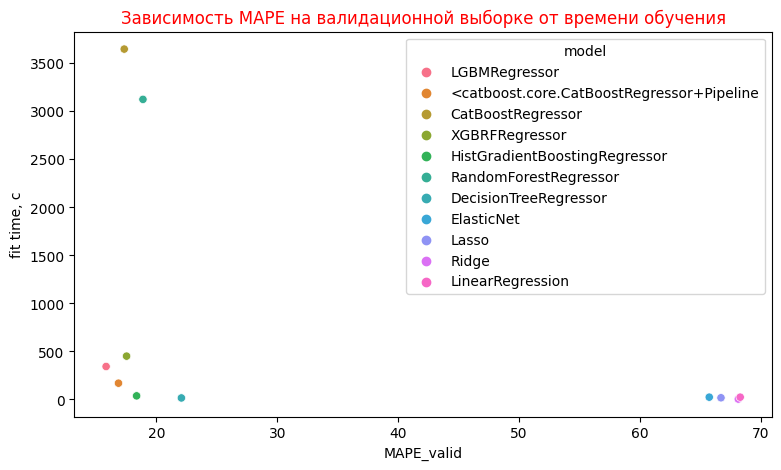

In [99]:
# Отсортируем модели по значению MAPE_valid:
df_final = df_results.sort_values(by = ['MAPE_valid'])
df_final = df_final.reset_index(drop=True)
display(df_final)

# Представим все отработанные модели на графике.

plt.figure(figsize = (9,5))
sns.scatterplot(data = df_final, x ='MAPE_valid', 
                y='fit time, c', hue="model")
plt.title('Зависимость MAPE на валидационной выборке от времени обучения',
          fontsize=12, color='red');
plt.show()

**Промежуточные выводы:**

In [100]:
print('Лучшей моделью является', df_final.model[0], 
      'имеющая лучшее значение MAPE:',
      round(df_final.best_score[0], 1),               
      '\nВремя обучения лучшей модели:', df_final['fit time'][0])

Лучшей моделью является LGBMRegressor имеющая лучшее значение MAPE: 18.7 
Время обучения лучшей модели: 00:05:41


## Расчёт результатов по выборке `test` и сохранение их в файл для последующей проверке на 'Kaggle'.

In [101]:
test_results['sellingprice'] = dictionary_models[df_final.model[0]].predict(test)    
test_results.reset_index(drop= True , inplace= True )

test_results.to_csv('test_results_best_model.csv', sep=',', 
                    index=False, columns =['vin', 'sellingprice'])

# Сериализация лучшей модели:
#with open("best_model.pkl", "wb") as f:
#    pickle.dump(dictionary_models[df_final.model[0]], f)

### Проверка на константной модели.

In [106]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train, y_train)

predict_dummy = model_dummy.predict(X_valid) 
MAPE_dummy = mape_func(y_valid, predict_dummy)

MAPE_best_test = abs(dictionary_models[df_final.model[0]].score(X_valid, y_valid))

print('Проведена проверка модели на адекватность.\n')
print('Итоговое значение MAPE на константной модели: ', 
      round(MAPE_dummy, 2), '.', sep='')

if (MAPE_dummy > MAPE_best_test):
    print('Это больше, чем для лучшей модели на валидационной выборке:', 
          round(MAPE_best_test, 2), '.', sep='')
    print('\nВЫВОД: лучшая построенная модель - адекватная.')
else:
    print('Это меньше, чем для лучшей модели на валидационной выборке: ',
         round(MAPE_best_test, 2), '.', sep='')
    print('\nМодель НЕ прошла проверку на адекватность!')

Проведена проверка модели на адекватность.

Итоговое значение MAPE на константной модели: 161.81.
Это больше, чем для лучшей модели на валидационной выборке: 15.8.

ВЫВОД: лучшая построенная модель - адекватная.


**Промежуточные выводы:**

Проведена успешная проверка адекватности модели на константной выборке.

### Изучение feature_importance.

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 250 ms
Wall time: 109 ms


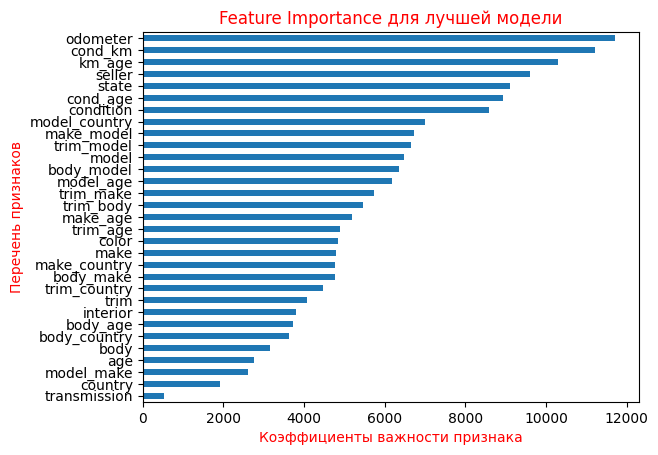

In [103]:
%%time
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    
    if 'Pipeline' in df_final.model[0]: num = 1
    else: num = 0
        
    # Построим таблицу важности обучающих признаков:
    pd.Series(index=X_train.columns, 
        data=dictionary_models[df_final.model[num]]. \
             best_estimator_.feature_importances_) \
        .sort_values().plot(kind='barh')
    _ = plt.title("Feature Importance для лучшей модели",
              fontsize=12, color='red')
    plt.xlabel("Коэффициенты важности признака", fontsize=10, color='red')
    plt.ylabel("Перечень признаков", fontsize=10, color='red');

**Отмечаем:**  

* Очень высокую значимость признаков 'odometer', 'condition/km', 'km/age'.
* Наименее значим признак 'transmission'.
* Незначимых признаков нет.
* Синтетические признаки оказались очень полезными.

### Стекинг.

In [104]:
start_time = time.time()

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)): 
    
    moscow_time = datetime.now(pytz.timezone(LOCAL_TIME_ZONE) ) 
    print("The start of the fitting ",
          "'StackingRegressor' model in Moscow time: ", 
          moscow_time.strftime("%H:%M:%S"), sep='')    
    
    model_names = [key for key in dictionary_models.keys()]    
    models = [value for value in dictionary_models.values()]
    
    stacked_model = StackingRegressor(list(zip(model_names, models)),
                    final_estimator = LinearRegression(),
                    n_jobs = -1, verbose = 0) 
   
    stacked_model.fit(X_train, y_train)
    
    time_stacking_working = time.time() - start_time    

    
# Добавим модель, рассчитанную stacking в наш список моделей:
found = stacked_model.__class__.__name__
if found not in list(df_results['model']):  
    df_results.loc[len(df_results.index )] = \
        [found, 
         abs(mape_func(y_train, stacked_model.predict(X_train))),
         abs(mape_func(y_train, stacked_model.predict(X_train))),
         abs(mape_func(y_valid, stacked_model.predict(X_valid))),
         round(time_stacking_working, 1),
         exec_time(time_stacking_working),
         'StackingRegressor',
        ]

    dictionary_models[found] = stacked_model
    
# Отсортируем модели по значению MAPE_valid:
df_final = df_results.sort_values(by = ['MAPE_valid'])
df_final = df_final.reset_index(drop=True)
display(df_final)

  0%|          | 0/1 [00:00<?, ?it/s]

The start of the fitting 'StackingRegressor' model in Moscow time: 20:12:18


,model,best_score,MAPE_train,MAPE_valid,"fit time, c",fit time,parameters
0,StackingRegressor,11.5,11.5,15.3,67454.6,18:44:15,StackingRegressor
1,LGBMRegressor,18.7,15.0,15.8,340.6,00:05:41,"{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 6000}"
2,<catboost.core.CatBoostRegressor+Pipeline,20.3,14.4,16.9,166.9,00:02:47,"Full time: 02:47:52 {clf__n_estimators : 405, clf__max_depth : 13}"
3,CatBoostRegressor,20.8,9.7,17.3,3643.6,01:00:44,"{'iterations': 363, 'max_depth': 16, 'verbose': 0}"
4,XGBRFRegressor,22.8,4.8,17.5,448.4,00:07:28,"{'max_depth': 26, 'n_estimators': 51}"
5,HistGradientBoostingRegressor,21.1,19.0,18.4,34.9,00:00:35,"{'learning_rate': 0.3, 'max_depth': 14, 'max_iter': 409, 'min_samples_leaf': 20}"
6,RandomForestRegressor,23.2,15.0,18.9,3120.3,00:52:00,"{'max_depth': 17, 'n_estimators': 459}"
7,DecisionTreeRegressor,24.5,15.8,22.1,13.2,00:00:13,{'max_depth': 16}
8,ElasticNet,69.1,69.2,65.7,21.4,00:00:21,{'alpha': 0.3}
9,Lasso,70.3,70.3,66.7,15.0,00:00:15,{'alpha': 100}


# Итоговые выводы

**По результатам исследования можно отметить следующие факты и сделать приводимые ниже выводы:**

1. Для проведения исследования получены данные по автомобилям, проданным в Северной Америке в период с 1989 по 2015 год.  
2. В файле 'train' находится обучающая выборка из примерно 440_000 записей, а в файле 'test' - тестовая выборка из примерно 110_000 записей без указания целевого признака.
3. Провёл EDA анализ, из VIN получены данные по производителю и стране производства. Данные подготовлены к дальнейшей работе.
4. Выполнил масштабирование количественных признаков и кодирование категориальных признаков отдельно для обучающей выборки и отдельно для тестоввой выборки.
5. Создал функцию для расчёта метрики `MAPE`.
6. Построил и обучил 7 моделей в `GridSearchCV`:
    - **LinearRegression** - линейная модель.
    - **DecisionTreeRegressor** - линейная модель.
    - **RandomForestRegressor** - ансамблевая модель.
    - **GradientBoostingRegressor** - ансамблевая модель.
    - **LGBMRegressor** - итеративная модель градиентного бустинга.
    - **CatBoostRegressor** - итеративная модель градиентного бустинга.
    - **XGBRFRegressor** - итеративная модель градиентного бустинга.

7. Построил конвейер `pipeline` для создания и оценки 7 моделей в `GridSearchCV`:
    - **LinearRegression** - линейная модель.
    - **DecisionTreeRegressor** - линейная модель.
    - **RandomForestRegressor** - ансамблевая модель.
    - **GradientBoostingRegressor** - ансамблевая модель.
    - **LGBMRegressor** - итеративная модель градиентного бустинга.
    - **CatBoostRegressor** - итеративная модель градиентного бустинга.
    - **XGBRFRegressor** - итеративная модель градиентного бустинга.   
  
8. В качестве лучшей в `pipeline` определили модель `CatBoostRegressor` с метрикой MAPE на валидационной выборке 16.9 и полным временем работы: 02:47:52.
9. В качестве самой лучшей определили модель `LGBMRegressor` с метрикой на валидационной выборке MAPE = 15.8 и временем обучения 00:05:41.  
10. Проверка адекватности модели на константной выборке дала удовлетворительный результат.
11. Исследование методом `Stacking` позволило получить модель с метрикой на валидационной выборке MAPE = 15.3. Время на обработку 12 - 19 часов. Плюс к этому, надо предварительно обучить каждую модель.
12. Специалистам сервиса по продаже автомобилей можно рекомендовать использовать модель `LGBMRegressor` со значением MAPE на валидационной выборке 15.8 и временем обучения 5 минут 41 секунда.  

Для работы на GitHub:  
[Вернуться к общему списку проектов курса Data_Science Яндекс-практикума](../README.md)